# Práctica 2 - Ejercicio 4: Predicción de Energía con Series Temporales Multivariantes y datos climáticos

**Asignatura**: Machine Learning, 2025/2026

**Profesor**: Jose Tomas, Palma Mendez

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

## Índice
1. [Introducción](#intro)
2. [Lectura y Preparación de Datos](#lectura)
3. [Modelo Línea Base](#linea-base)
4. [Estrategia de Evaluación](#eval)
5. [Modelos Avanzados con Grid Search](#modelos)
   1. [Random Forest](#random)
   2. [XGBoost](#xgboost)
   3. [SVR](#svr)
6. [Comparación y Conclusiones](#conclu)

 [Uso de IA Generativa](#genia)

 [Entorno de Ejecución](#entorno)

## Introducción <a class="anchor" id="intro"></a>

En este notebook vamos a realizar el ejercicio 2.4 de predicción de energía con series temporales multivariables añadiendo además los datos climáticos. En terminos generales vamos a continuar con los mismos algoritmos y estrategias que en el ejercicio anterior pero con estrategias multivariables.

## Lectura y Preparación de Datos <a class="anchor" id="lectura"></a>

En esta sección se cargan los datos previamente preprocesados y analizados en el notebook `practica2_ejercicio1.ipynb`

In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


# Métricas
from sktime.performance_metrics.forecasting import mean_squared_scaled_error
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Skforecast para series temporales multivariantes
from skforecast.direct import ForecasterDirectMultiVariate

from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries, grid_search_forecaster_multiseries

## Graficos
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# CONSTANTES
TARGET = 'Energía total (kWh)'
HORIZONTE = 7  # días
LAGS = 7
SEED = 42

### Configuración de lags

La serie temporal de energía ha demostrado ser **estacionaria** tras el análisis ADF (Augmented Dickey-Fuller) realizado en el ejercicio 1. Tanto a nivel semanal como a nivel anual. Por lo que la estrategía de elección de lags lo vamos a baser en esto.

**Estrategia de lags:**

Se utilizarán dos configuraciones de lags basadas en los patrones identificados:

1. **Lags semanales y anuales**: `[7, 30, 183, 365]`
   - Lag 7: Captura el patrón semanal (7 días anteriores)
   - Lag 30: Captura el patrón mensual (1 mes anterior)
   - Lag 183: Captura el patrón semestral (6 meses anteriores)
   - Lag 365: Captura el patrón anual (año anterior)

2. **Lags diarios recientes + anuales**: `[1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 364, 365]`
   - Lags 1-7: Semana completa anterior (captura tendencias recientes)
   - Lags 359-365: Días cercanos al mismo período del año anterior (captura estacionalidad anual)
   - Mantenemos un número reducido de lags (14) mientras capturamos tendencia reciente y estacionalidad anual.


In [2]:
# Configuraciones de lags basadas en estacionalidad semanal y mensual/anual
# Config 1: Lags estratégicos (semanal, mensual, semestral, anual)
lags_grid_estrategicos = [7, 30, 183, 365]

# Config 2: Lags diarios recientes + contexto anual
lags_grid_diarios_anuales = [[1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 364, 365]]

# Grid completo para búsqueda
lags_grid = lags_grid_estrategicos + lags_grid_diarios_anuales

Vamos a eliminar 'Emisión (kg CO₂)' porque tiene una correlación lineal perfecta 
con 'Energía total (kWh)', nuestra variable objetivo. Al ser variables proporcionales 
entre sí (en el mismo instante temporal), la información de una está completamente 
contenida en la otra, generando redundancia. Mantener ambas no aporta valor predictivo 
adicional y puede causar problemas de multicolinealidad en algunos modelos.
Además intuimos que es una columna que se calcula atraves de 'Energía total (kWh)'. Con esto tambien agilizamos los tiempos de entrenamiento reduciendo el tamaño de nuestro dataset sin perder información.

In [3]:
# Cargar datos
energia__climaticos_preprocesada = pd.read_csv('energia_climaticos_preprocesada.csv', index_col=0, parse_dates=True)
# Establecer frecuencia diaria
energia__climaticos_preprocesada = energia__climaticos_preprocesada.asfreq('D')
energia__climaticos_preprocesada = energia__climaticos_preprocesada.drop(columns="Día de la semana")


if 'Emisión (kg CO₂)' in energia__climaticos_preprocesada.columns:
    energia__climaticos_preprocesada = energia__climaticos_preprocesada.drop('Emisión (kg CO₂)', axis=1)
    display(energia__climaticos_preprocesada.head())

Vamos a dividir el dataset en train y test, para ello hemos elegido la estrategia de hold out con 80, 20 ya que es estandar en la industria. Además es la misma estrategía que utilizamos en el ejercicio 2.

In [4]:
# División train/test 80/20
train_index = int(len(energia__climaticos_preprocesada) * 0.8)
train_data = energia__climaticos_preprocesada.iloc[:train_index]
train_data = train_data.asfreq('D')
test_data = energia__climaticos_preprocesada.iloc[train_index:]
test_data = test_data.asfreq('D')


Se incorpora el 'día de la semana' como variable exógena, ya que es una variable 
determinista conocida tanto en el pasado como en el futuro, independiente de la 
variable objetivo. Esta variable puede capturar patrones de estacionalidad semanal 
en el consumo energético (e.g., diferencias entre días laborables y fines de semana) como vimos durante el análisis.

También incorporamos variables meteorológicas como variables exógenas (humedad, presión atmosférica, velocidad del viento y ráfaga), ya que son factores externos al sistema eléctrico que influyen en la demanda a través del confort térmico, las pérdidas/ganancias de calor y, en general, de la necesidad de calefacción o refrigeración. Además, a diferencia del consumo energético (que es la variable objetivo), estas variables se pueden estimar para el futuro mediante modelos meteorológicas robustos, lo que permite disponer de valores exógenos en el horizonte de predicción e introducirlos en los modelos sin incurrir en fuga de información.

In [5]:
# Crear variables exógenas: día de la semana + variables meteorológicas
meteo_cols = [
    "Temperatura (°C)",
    "Punto de rocío (°C)",
    "Humedad (%)",
    "Velocidad del viento (m/s)",
    "Presión (hPa)",
    "Ráfaga de viento (m/s)",
]

missing_cols = [c for c in meteo_cols if c not in energia__climaticos_preprocesada.columns]
def build_exog(df: pd.DataFrame) -> pd.DataFrame:
    exog = df[meteo_cols].copy()
    exog["dia_semana"] = df.index.dayofweek
    return exog

exog_train = build_exog(train_data)
exog_test = build_exog(test_data)

# Para backtesting, necesitamos exog para todo el conjunto de datos
exog_completo = build_exog(energia__climaticos_preprocesada)

test_data.drop(columns=meteo_cols, inplace=True)
train_data.drop(columns=meteo_cols, inplace=True)
energia__climaticos_preprocesada.drop(columns=meteo_cols, inplace=True)

Ahora se muestra el resultado de las operaciones realizadas y los conjuntos de train y test gráficamente.

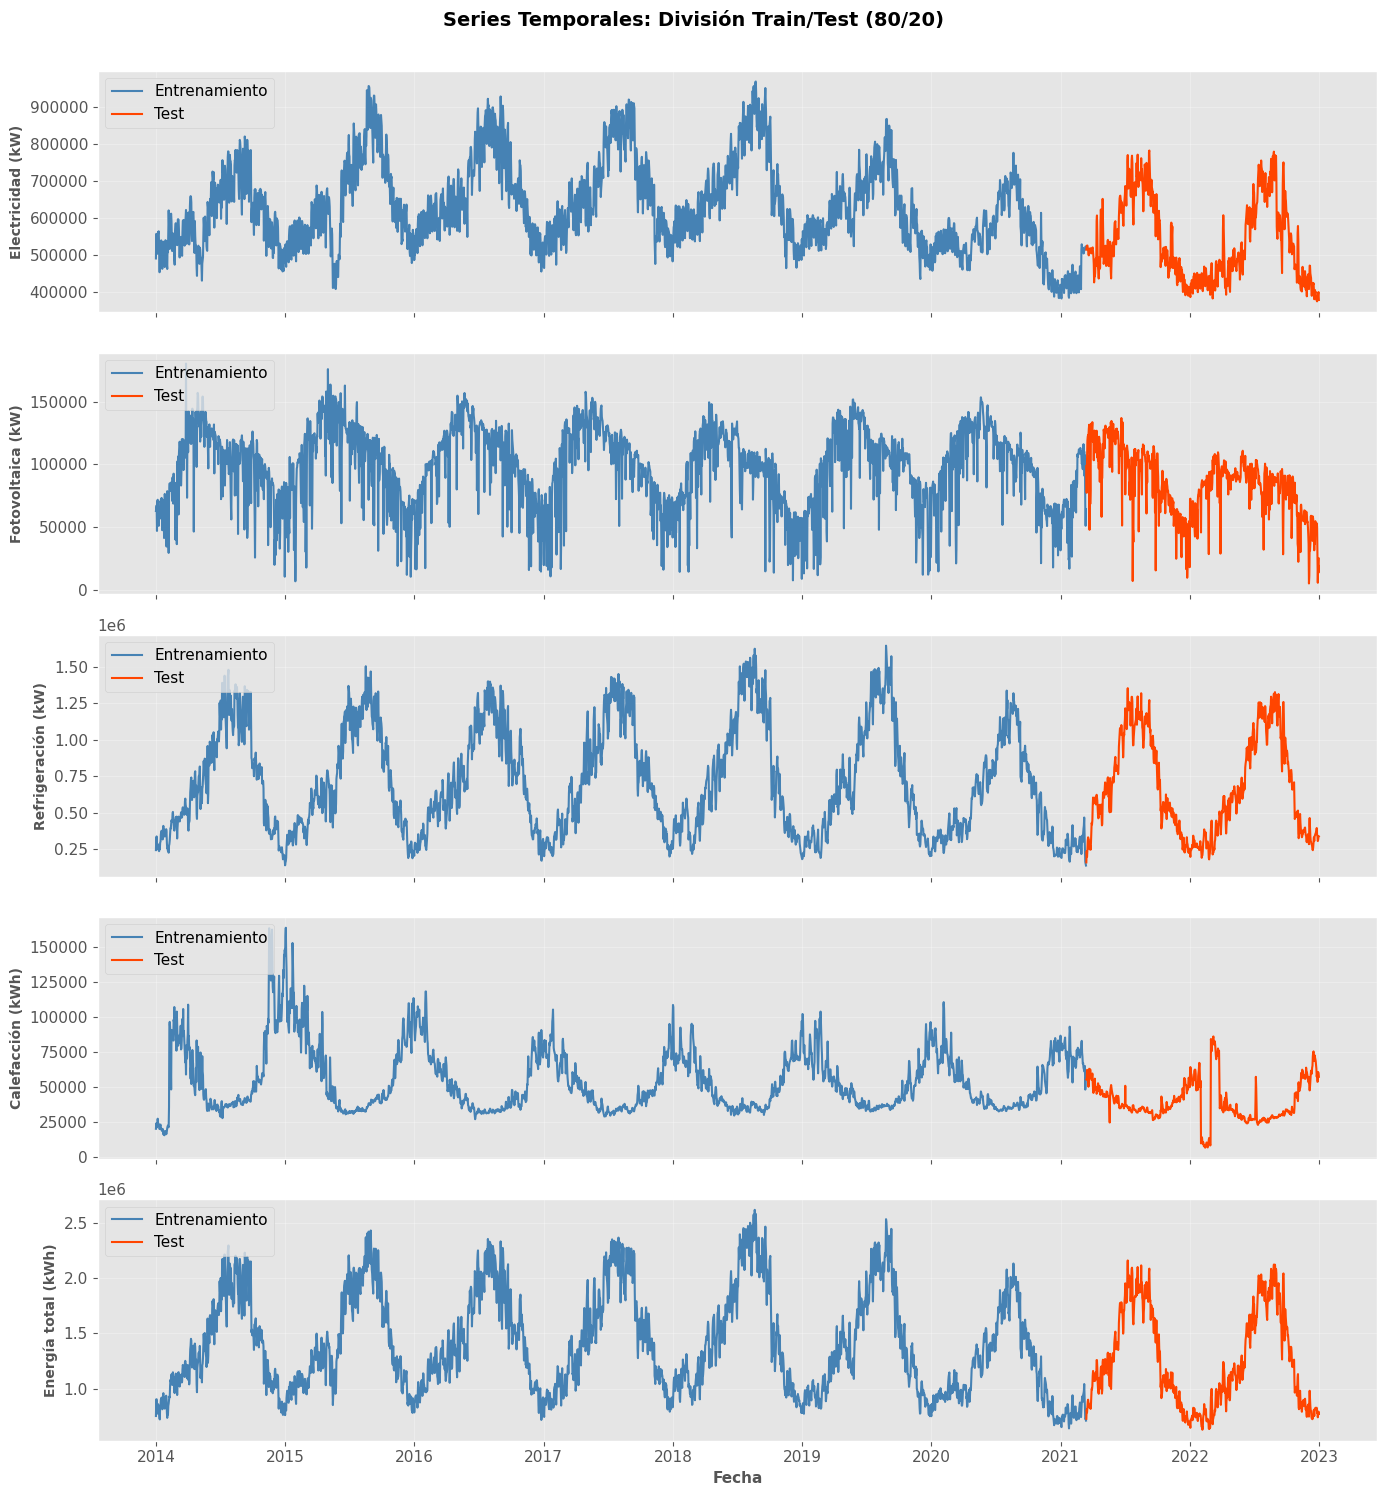

In [6]:
# Visualización de la división train/test
n_series = len(energia__climaticos_preprocesada.columns)
fig, axes = plt.subplots(n_series, 1, figsize=(14, 3*n_series), sharex=True)

if n_series == 1:
    axes = [axes]

for i, col in enumerate(energia__climaticos_preprocesada.columns):
    ax = axes[i]
    ax.plot(train_data.index, train_data[col], color='steelblue', label='Entrenamiento', linewidth=1.5)
    ax.plot(test_data.index, test_data[col], color='orangered', label='Test', linewidth=1.5)
    ax.set_ylabel(col, fontsize=10, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Fecha', fontsize=11, fontweight='bold')
fig.suptitle('Series Temporales: División Train/Test (80/20)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

## 2. Modelo Línea Base <a class="anchor" id="linea-base"></a>

Vamos a utilizar un **modelo baseline simple** basado en la media entre el día anterior al horizonte y el mismo día del año anterior.

Esta estrategia captura tanto la tendencia reciente como la estacionalidad anual de forma simple y computacionalmente eficiente.

**Estrategia para horizonte de 7 días:**
- **h=1**: Predicción = media(último_día_train, mismo_día_año_anterior)
- **h=2**: Predicción = media(predicción_h1, día_año_anterior_correspondiente)
- **h=3 a h=7**: Se continúa usando la predicción anterior y el día del año anterior correspondiente

Este modelo es simple pero efectivo para series con fuerte estacionalidad anual, y servirá como referencia para compararlo con modelos más complejos.

Tambien hemos estudiado la alternativa de usar solo el día anterior, por eso nuestra función nos permite elegir si utilizar la media de dos días o solo el día anterior con el parámetro 'media2dias'. Tras evaluar con el conjunto de train y test el mejor resultado ha sido utilizando la media entre el último día conocido y el mismo día del año anterior. Por lo que finalmente hemos utilizado ese modelo.

In [7]:
# Función para crear predicciones baseline con media de día anterior + mismo día año anterior
def crear_baseline_predicciones(train_data, target_column, media2Dias=False,horizonte=7):
    predicciones = []
    fechas_pred = []
    
    # Obtener el último valor de train y su índice
    ultimo_idx_train = train_data.index[-1]
    ultimo_valor = train_data[target_column].iloc[-1]
    
    for h in range(1, horizonte + 1):
        # Fecha de la predicción
        fecha_pred = ultimo_idx_train + pd.Timedelta(days=h)
        fechas_pred.append(fecha_pred)
        
        # Fecha del mismo día del año anterior
        fecha_año_anterior = fecha_pred - pd.Timedelta(days=365)
        
        idx_cercano = train_data.index.get_indexer([fecha_año_anterior], method='nearest')[0]
        valor_año_anterior = train_data[target_column].iloc[idx_cercano]
        
        # Para h=1, usar el último día de train
        # Para h>1, usar la predicción anterior
        if h == 1:
            valor_anterior = ultimo_valor
        else:
            valor_anterior = predicciones[-1]
        
        # Predicción como media simple
        
        if(media2Dias):
            pred = (valor_anterior + valor_año_anterior) / 2
            predicciones.append(pred)
        else:
            predicciones.append(valor_anterior)
    
    # Crear serie con las predicciones
    predicciones_serie = pd.Series(predicciones, index=fechas_pred, name='pred')
    
    return predicciones_serie

# Crear predicciones baseline
prediccion_inicial = crear_baseline_predicciones(train_data, target_column=TARGET, media2Dias=True, horizonte=HORIZONTE)

# Convertir a DataFrame para mantener consistencia con código posterior
prediccion_inicial = pd.DataFrame(prediccion_inicial)

Vamos a visualizar los primeros 7 días predichos con el modelo baseline simple comparándolos con los valores reales.

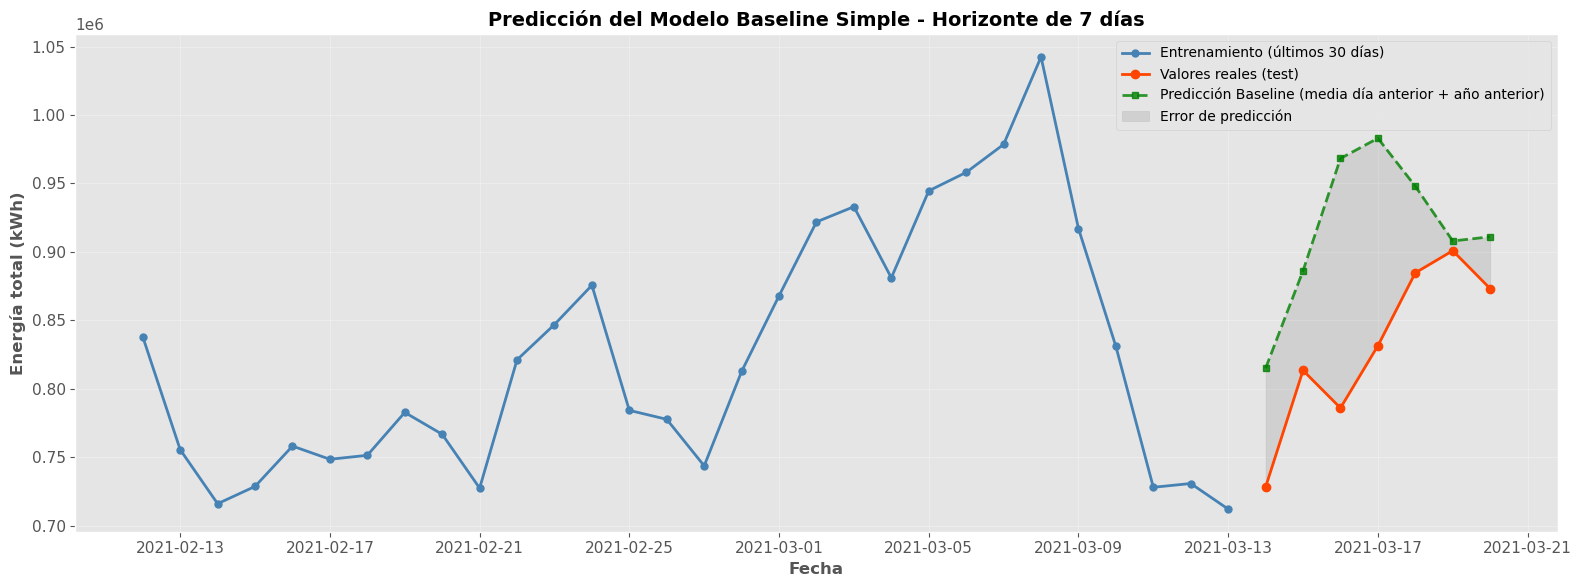

In [8]:
# Visualizar la predicción del modelo baseline
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train_data[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test_data[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial['pred'], 
        's--', color='green', label='Predicción Baseline (media día anterior + año anterior)', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial['pred'],
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline Simple - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Se puede ver que los resultados son buenos para los primeros 2 días y despues se produce una desviación más intensa en el tercer, cuarto y quinto día mientras que en el sexto y septimo vuelve a dar resultados parecidos.

## Estrategia de Evaluación <a class="anchor" id="eval"></a>

Para la evaluación vamos a utilziar las mismas métricas que utilizamos en el notebook anterior, MAE, RMSE, RMSSE y MAPE. Estas métricas las utilizaremos con el conjunto de Train con Backtesting y para comprobar la generalización y overfiting del modelo utilizaremos una función para calcular los errores por cada día del horizonte. Y la medía total de todos los horizontes.

In [9]:
# Función para calcular métricas de evaluación
def calcular_metricas(y_true, y_pred,y_train, nombre_modelo="Modelo", verbose=True):
    """
    Calcula métricas de evaluación para predicciones de series temporales.
    
    Métricas:
    - MAE: Mean Absolute Error
    - RMSE: Root Mean Squared Error
    - RMSSE: Root Mean Squared Scaled Error
    - MAPE: Mean Absolute Percentage Error
    """
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # RMSE
    rmse = root_mean_squared_error(y_true, y_pred)  # raíz del MSE
    
    # MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred) *100
    
    # RMSSE
    rmsse = np.sqrt(mean_squared_scaled_error(y_true, y_pred, y_train=y_train, sp=7))
    
    resultados = {
        'Modelo': nombre_modelo,
        'MAE': mae,
        'RMSE': rmse,
        'RMSSE': rmsse,
        'MAPE': mape
    }
    
    if verbose:
        print(f"\nMétricas de {nombre_modelo}:")
        print(f"  • MAE   = {mae:.3f} kWh")
        print(f"  • RMSE  = {rmse:.3f} kWh")
        print(f"  • RMSSE = {rmsse:.4f}")
        print(f"  • MAPE  = {mape:.2f}%")
    
    return resultados

In [10]:
def calcular_errores_por_horizonte(modelo, test_data, train_data=None, offset_lags=0, exog_test=None, horizonte=7, target_col='Energía total (kWh)', verbose=True):
    # Si se proporcionan datos de train, concatenarlos con test para tener suficientes lags
    if train_data is not None:
        # Concatenar últimos 365 días de train con test
        datos_completos = pd.concat([train_data.tail(offset_lags), test_data])
        # Ajustar índice de inicio
        offset = offset_lags
    else:
        datos_completos = test_data
        offset = 0
    
    # Inicializar listas para almacenar errores
    errores_por_ventana = []
    predicciones_lista = []
    
    # Calcular cuántas ventanas de predicción podemos hacer
    n_ventanas = len(test_data) - horizonte + 1
    
    # Para cada ventana de inicio en el conjunto de test
    for i in range(n_ventanas):
        # Índice en test_data
        idx_test = i
        # Índice en datos_completos
        idx_completo = i + offset
        
        # Fecha de inicio de la predicción
        fecha_inicio = test_data.index[idx_test]
        
        # Realizar predicción para los próximos 'horizonte' días
        # Datos hasta el punto de predicción (incluye train si está disponible)
        datos_hasta_punto = datos_completos.iloc[:idx_completo]
        
        if  exog_test is not None:
            # Variables exógenas para el periodo de predicción
            exog_periodo = exog_test.iloc[idx_test:idx_test+horizonte]
            pred = modelo.predict(steps=horizonte, levels=target_col, 
                                 last_window=datos_hasta_punto, exog=exog_periodo)
        else:
            pred = modelo.predict(steps=horizonte, levels=target_col,
                                 last_window=datos_hasta_punto)
        
        # Obtener valores reales para este periodo
        y_true = test_data[target_col].iloc[idx_test:idx_test+horizonte].values
        
        # Extraer predicciones solo para la serie objetivo
        # pred puede ser un DataFrame con múltiples series
        y_pred = pred['pred']

        # Asegurarse de que las dimensiones coinciden
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]

        
       # Calcular errores
        error_abs = np.abs(y_true - y_pred)
        error_squared = (y_true - y_pred) ** 2
        error_pct = np.abs((y_true - y_pred) / y_true) * 100

        
        
        # Guardar predicciones
        for h in range(min_len):
            predicciones_lista.append({
                'ventana': i,
                'fecha_inicio': fecha_inicio,
                'horizonte_dia': h + 1,
                'fecha_pred': test_data.index[idx_test + h],
                'valor_real': float(y_true[h]),
                'valor_pred': float(y_pred[h]),
                'error_absoluto': float(error_abs[h]),
                'error_cuadrado': float(error_squared[h]),
                'error_porcentual': float(error_pct[h])
            })
        
        # Guardar errores de esta ventana
        errores_ventana_dict = {'ventana': i, 'fecha_inicio': fecha_inicio}
        for h in range(min_len):
            errores_ventana_dict[f'mae_h{h+1}'] = float(error_abs[h])
            errores_ventana_dict[f'mse_h{h+1}'] = float(error_squared[h])
            errores_ventana_dict[f'mape_h{h+1}'] = float(error_pct[h])
        
        errores_por_ventana.append(errores_ventana_dict)
    
    # Crear DataFrames
    df_errores = pd.DataFrame(errores_por_ventana)
    df_predicciones = pd.DataFrame(predicciones_lista)
    
    if len(df_predicciones) == 0:
        return None
    
    # Calcular métricas por horizonte
    metricas_por_h = []
    for h in range(1, horizonte + 1):
        # Filtrar predicciones para este horizonte
        pred_h = df_predicciones[df_predicciones['horizonte_dia'] == h]
        
        y_true_h = pred_h['valor_real'].values
        y_pred_h = pred_h['valor_pred'].values
        
        y_train = train_data[target_col].values if train_data is not None else None
        # MAE
        mae = mean_absolute_error(y_true_h, y_pred_h)

        # RMSE
        rmse = root_mean_squared_error(y_true_h, y_pred_h)  # raíz del MSE

        # MAPE
        mape = mean_absolute_percentage_error(y_true_h, y_pred_h) *100

        # RMSSE
        rmsse = np.sqrt(mean_squared_scaled_error(y_true_h, y_pred_h, y_train=y_train, sp=7))

        metricas_por_h.append({
            'Horizonte': f'h+{h}',
            'MAE': mae,
            'RMSE': rmse,
            'RMSSE': rmsse,
            'MAPE': mape
        })
    
    df_metricas = pd.DataFrame(metricas_por_h)
    
    # Calcular métricas globales (promedio de todos los horizontes)
    metricas_globales = {
        'MAE': df_metricas['MAE'].mean(),
        'RMSE': df_metricas['RMSE'].mean(),
        'RMSSE': df_metricas['RMSSE'].mean(),
        'MAPE': df_metricas['MAPE'].mean()
    }

    return {
        'metricas_por_horizonte': df_metricas,
        'metricas_globales': metricas_globales,
        'errores_detallados': df_errores,
        'predicciones': df_predicciones
    }

def visualizar_errores_horizonte(resultados, titulo="Análisis de Errores por Horizonte"):
    df_metricas = resultados['metricas_por_horizonte']
    df_predicciones = resultados['predicciones']
        
    n_horizontes = df_predicciones['horizonte_dia'].nunique()
    fig, axes = plt.subplots(n_horizontes, 1, figsize=(16, 4 * n_horizontes))
    
    if n_horizontes == 1:
        axes = [axes]
    
    for h in range(1, n_horizontes + 1):
        ax = axes[h - 1]
        
        # Filtrar datos para este horizonte
        datos_h = df_predicciones[df_predicciones['horizonte_dia'] == h].sort_values('fecha_pred')
        
        # Plotear valores reales y predichos
        ax.plot(datos_h['fecha_pred'], datos_h['valor_real'], 
               'o-', color='steelblue', label='Valores Reales', 
               linewidth=2, markersize=4, alpha=0.8)
        
        ax.plot(datos_h['fecha_pred'], datos_h['valor_pred'], 
               's--', color='orangered', label='Predicciones', 
               linewidth=2, markersize=4, alpha=0.8)
        
        # Área de error
        ax.fill_between(datos_h['fecha_pred'], 
                        datos_h['valor_real'], 
                        datos_h['valor_pred'],
                        alpha=0.2, color='gray')
        
        # Métricas para este horizonte
        metrica_h = df_metricas[df_metricas['Horizonte'] == f'h+{h}'].iloc[0]
        texto_metricas = (f"MAE: {metrica_h['MAE']:.2f} | "
                         f"RMSE: {metrica_h['RMSE']:.2f} | "
                         f"RMSSE: {metrica_h['RMSSE']:.4f} | "
                         f"MAPE: {metrica_h['MAPE']:.2f}%")
        
        ax.set_xlabel('Fecha', fontsize=11, fontweight='bold')
        ax.set_ylabel('Energía (kWh)', fontsize=11, fontweight='bold')
        ax.set_title(f'Horizonte h+{h} - {texto_metricas}', 
                    fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Rotar etiquetas de fecha si hay muchos puntos
        if len(datos_h) > 30:
            ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'{titulo} - Predicciones por Horizonte', 
                fontsize=14, fontweight='bold', y=0.9995)
    plt.tight_layout()
    plt.show()

La función anterior genera las métricas MAE, RMSE, RMSSE y MAPE para comparar valores reales y predichos.

**Interpretación de las métricas:**
- **MAE** (Mean Absolute Error). Cuantifica el error medio en términos absolutos entre el valor observado y el valor estimado. Se expresa en kWh, por lo que permite interpretar la desviación media directamente en la unidad de la variable objetivo. No sobrerrepresenta de forma marcada los errores puntualmente grandes, lo que la hace adecuada como medida “típica” del error. Es especialmente útil cuando interesa evaluar la precisión promedio sin enfatizar picos. Valores menores indican mejor rendimiento.

- **RMSE** (Root Mean Squared Error). Mide el error medio dando mayor peso a las desviaciones grandes, ya que penaliza más intensamente los errores elevados. Se expresa también en kWh y, en presencia de picos o fallos severos, tiende a aumentar de forma más acusada que el MAE. Es apropiada cuando los errores grandes son especialmente costosos o se quiere detectar falta de robustez ante episodios extremos. Su sensibilidad a outliers es mayor que la del MAE. Valores menores indican mejor rendimiento.

- **MAPE** (Mean Absolute Percentage Error). Expresa el error medio en términos relativos y, en este caso, se reporta en porcentaje al multiplicarse por 100. Facilita la comparación entre periodos o series con distinta escala, al medir la desviación proporcional respecto al valor real. Sin embargo, puede producir valores inestables o exagerados cuando los valores reales son muy pequeños o nulos, por lo que conviene interpretarlo con cautela en esos escenarios. Es una métrica útil para comunicar error “en %” de manera intuitiva. Valores menores indican mejor rendimiento.

- **RMSSE** (Root Mean Squared Scaled Error). Es una métrica adimensional que normaliza el error del modelo mediante un modelo de referencia (naïve) calculado sobre el conjunto de entrenamiento. Con sp=7, la referencia corresponde a un naïve estacional semanal (usar el valor de hace 7 días), lo que permite evaluar el modelo frente a un baseline razonable para series con estacionalidad semanal. Un valor inferior a 1 indica mejora frente al baseline, cercano a 1 indica rendimiento similar y superior a 1 indica peor desempeño. 

Librerías utilizadas: MAE, RMSE y MAPE se calculan con sklearn.metrics, mientras que el escalado para RMSSE se obtiene con sktime.performance_metrics.forecasting (mean_squared_scaled_error).

### Estrategia de Evaluación con TimeSeriesFold:
El objeto TimeSeriesFold sería realizar una validación cruzada sobre el conjunto de train, con esto podrémos controlar el overfitting, hemos elegido que comience con 3 años de datos iniciales(quedan 3 para validación) y que tenga una ventana de un año.

In [11]:
initial_train_size = 365*3  # días
window_size = 365
# Crear TimeSeriesFold para backtesting
cv = TimeSeriesFold(
    steps=HORIZONTE,                  # Horizonte de predicción
    initial_train_size=initial_train_size,  # Inicial de 365 días
    window_size=window_size,                 # Ventana fija de 7 días
    fold_stride           = None,
    refit=False,                      # No reentrenar en cada fold
    fixed_train_size=True,           # Ventana fija
    gap=0,                            # Sin gap entre train y test
    allow_incomplete_fold=True,       # Permitir folds incompletos
    verbose=False
)
cv.split(X=train_data, as_pandas=True)

fold  train_start  train_end  last_window_start  last_window_end  \
0       0            0       1095                730             1095   
1       1            0       1095                737             1102   
2       2            0       1095                744             1109   
3       3            0       1095                751             1116   
4       4            0       1095                758             1123   
..    ...          ...        ...                ...              ...   
215   215            0       1095               2235             2600   
216   216            0       1095               2242             2607   
217   217            0       1095               2249             2614   
218   218            0       1095               2256             2621   
219   219            0       1095               2263             2628   

     test_start  test_end  test_start_with_gap  test_end_with_gap  \
0          1095      1102                 1095               1102   
1          1102      1109                 1102               1109   
2          1109      1116                 1109               1116   
3          1116      1123                 1116               1123   
4          1123      1130                 1123               1130   
..          ...       ...                  ...                ...   
215        2600      2607                 2600               2607   
216        2607      2614                 2607               2614   
217        2614      2621                 2614               2621   
218        2621      2628                 2621               2628   
219        2628      2629                 2628               2629   

     fit_forecaster  
0              True  
1             False  
2             False  
3             False  
4             False  
..              ...  
215           False  
216           False  
217           False  
218           False  
219           False  

[220 rows x 10 columns]

### Evaluación del modelo baseline


Evaluando baseline con rolling window en TRAIN...
  Horizonte: 7 días
  Rango de evaluación: desde índice 365 hasta 1892
  Total de predicciones por horizonte: 1528
  Fechas: desde 2016-12-31 00:00:00 hasta 2021-03-07 00:00:00

Evaluando baseline con rolling window en TEST...
  Horizonte: 7 días
  Rango de evaluación: desde índice 365 hasta 1016
  Total de predicciones por horizonte: 652
  Fechas: desde 2021-03-14 00:00:00 hasta 2022-12-25 00:00:00

TRAIN:
  MAE: 156234.9928
  RMSE: 202855.9433
  RMSSE: 1.1493
  MAPE: 11.84%

TEST:
  MAE: 116195.4896
  RMSE: 150707.1244
  RMSSE: 0.8538
  MAPE: 9.28%


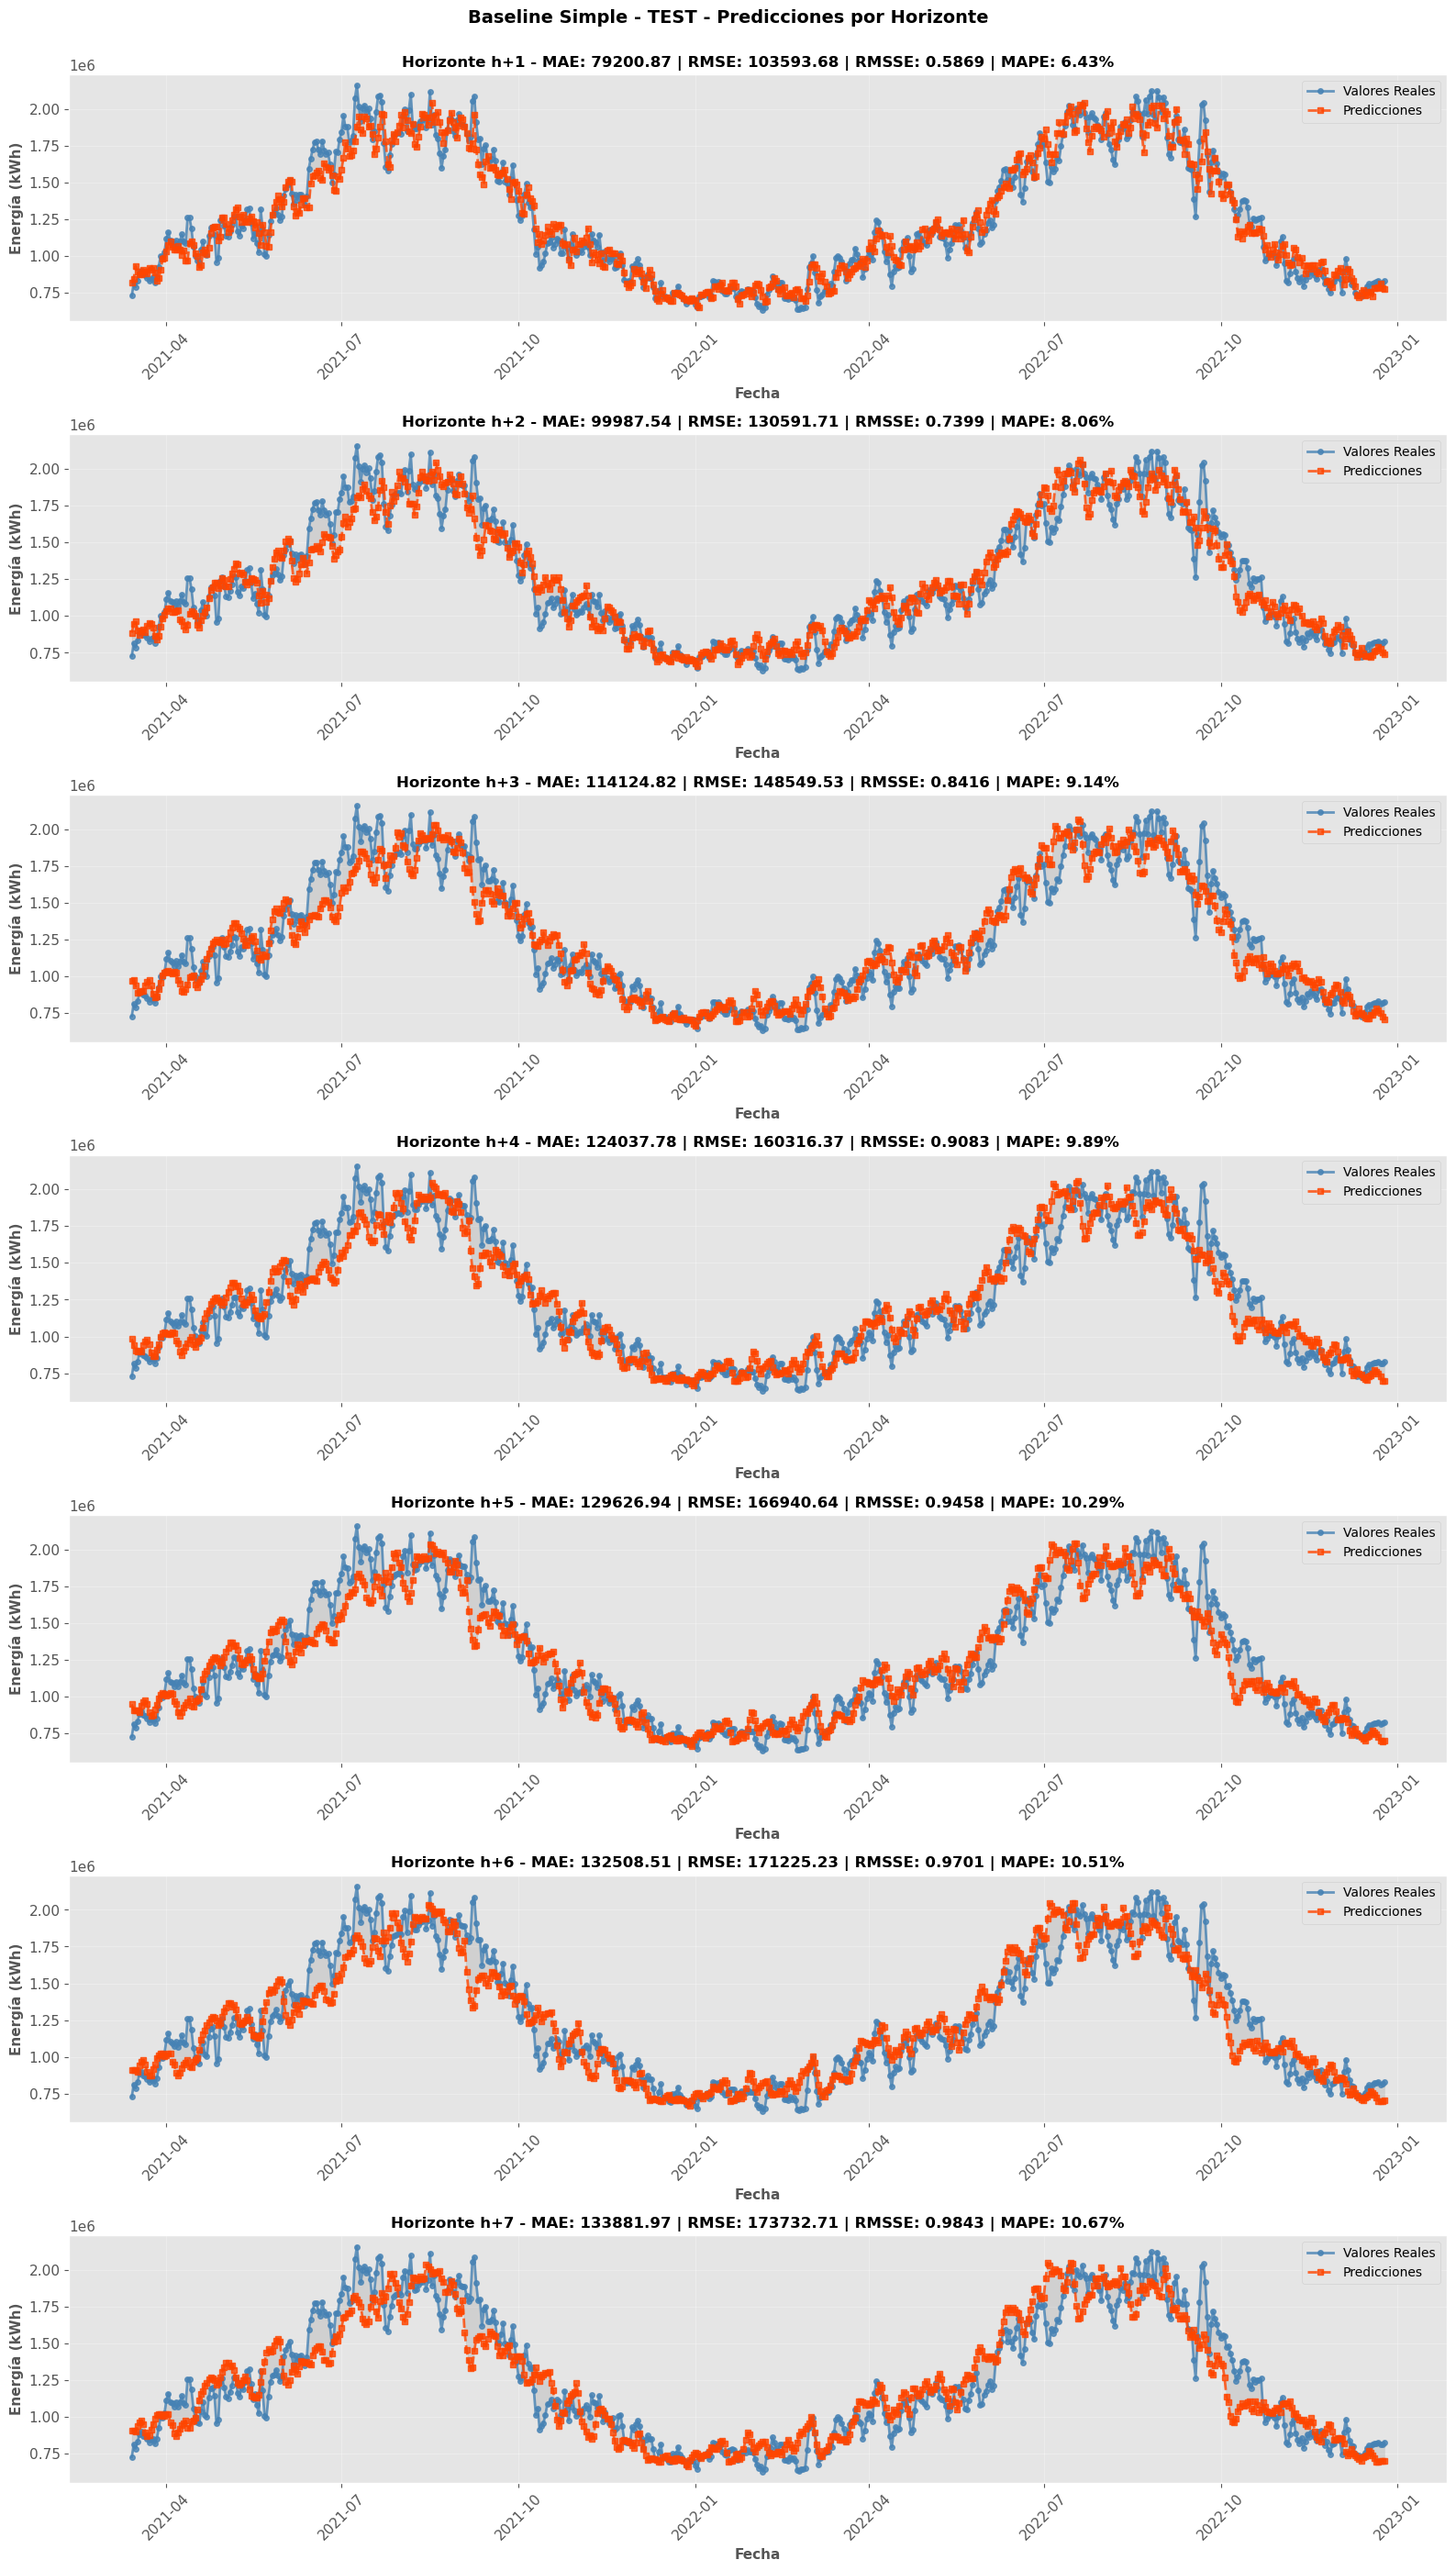

In [12]:
# Función para evaluar el baseline simple en un conjunto de datos con rolling window
def evaluar_baseline_simple(datos, horizonte, target_col, media2Dias=True,verbose=True, nombre_conjunto="datos"):
    # Diccionarios para almacenar predicciones de cada horizonte
    predicciones_por_horizonte = {h: [] for h in range(1, horizonte + 1)}
    valores_reales = []
    fechas = []
    
    # Necesitamos al menos 365 días para poder usar el año anterior
    # y poder predecir al menos horizonte días adelante
    min_inicio = 365
    
    if verbose:
        print(f"\nEvaluando baseline con rolling window en {nombre_conjunto}...")
        print(f"  Horizonte: {horizonte} días")
        print(f"  Rango de evaluación: desde índice {min_inicio} hasta {len(datos) - horizonte}")
    
    # Recorremos los datos dejando espacio para predecir 'horizonte' días adelante
    for i in range(min_inicio, len(datos) - horizonte + 1):
        # Datos disponibles hasta este punto (sin mirar hacia adelante)
        datos_hasta_aqui = datos.iloc[:i]
        
        # Para cada horizonte h
        for h in range(1, horizonte + 1):
            # Índice del día que queremos predecir
            idx_pred = i + h - 1
            
            # Valor real del día a predecir
            if h == 1:
                # Solo guardamos valores reales una vez (para h=1)
                valor_real = datos[target_col].iloc[idx_pred]
                valores_reales.append(valor_real)
                fechas.append(datos.index[idx_pred])
            
            # Calcular predicción para este horizonte
            if h == 1:
                valor_dia_anterior = datos_hasta_aqui[target_col].iloc[-1]
            else:
                valor_dia_anterior = predicciones_por_horizonte[h - 1][-1]

            
            # Mismo día del año anterior respecto al día que queremos predecir
            idx_año_anterior = idx_pred - 365
            if idx_año_anterior >= 0 and idx_año_anterior < i:
                valor_año_anterior = datos_hasta_aqui[target_col].iloc[idx_año_anterior]
            else:
                # Si no tenemos el valor exacto del año anterior, usamos el más cercano disponible
                # dentro de datos_hasta_aqui
                idx_año_anterior_cercano = max(0, min(idx_año_anterior, i - 1))
                valor_año_anterior = datos_hasta_aqui[target_col].iloc[idx_año_anterior_cercano]
            
            if media2Dias:
                # Predicción como media simple
                pred = (valor_dia_anterior + valor_año_anterior) / 2
                predicciones_por_horizonte[h].append(pred)
            else:
                pred = (valor_año_anterior)
                predicciones_por_horizonte[h].append(pred)
    # Convertir a arrays numpy
    y_true = np.array(valores_reales)
    resultados = {'y_true': y_true, 'fechas': fechas}
    
    for h in range(1, horizonte + 1):
        resultados[f'y_h{h}'] = np.array(predicciones_por_horizonte[h])
    
    if verbose:
        print(f"  Total de predicciones por horizonte: {len(valores_reales)}")
        print(f"  Fechas: desde {fechas[0]} hasta {fechas[-1]}")
    
    return resultados

# 1. Evaluar en TRAIN con rolling window
resultados_train = evaluar_baseline_simple(
    datos=train_data[730:], # Usamos desde el año 3 en adelante como en backtesting
    horizonte=HORIZONTE,
    target_col=TARGET,
    media2Dias=True,
    nombre_conjunto="TRAIN"
)

# Calcular métricas para cada horizonte en TRAIN
metricas_baseline_train_por_horizonte = {}
for h in range(1, HORIZONTE + 1):
    metricas = calcular_metricas(
        resultados_train['y_true'], 
        resultados_train[f'y_h{h}'], 
        train_data[TARGET].values,
        f"Baseline - TRAIN (h={h})",
        verbose=False
    )
    metricas_baseline_train_por_horizonte[f'h{h}'] = metricas

# 2. Evaluar en TEST con rolling window
# Concatenamos el último año de train para poder predecir usando año anterior
resultados_test = evaluar_baseline_simple(
    datos=pd.concat([train_data[-365:], test_data]),
    horizonte=HORIZONTE,
    target_col=TARGET,
    media2Dias=True,
    nombre_conjunto="TEST"
)

# Calcular métricas para cada horizonte en TEST
metricas_baseline_test_por_horizonte = {}
for h in range(1, HORIZONTE + 1):
    metricas = calcular_metricas(
        resultados_test['y_true'], 
        resultados_test[f'y_h{h}'], 
        train_data[TARGET].values,
        f"Baseline - TEST (h={h})",
        verbose=False
    )
    metricas_baseline_test_por_horizonte[f'h{h}'] = metricas

# Crear diccionario compatible con visualizar_errores_horizonte para TEST
def crear_dict_visualizacion(resultados_eval, metricas_por_h, horizonte):
    """
    Crea un diccionario compatible con la función visualizar_errores_horizonte
    """
    # DataFrame de métricas por horizonte
    metricas_list = []
    for h in range(1, horizonte + 1):
        m = metricas_por_h[f'h{h}']
        metricas_list.append({
            'Horizonte': f'h+{h}',
            'MAE': m['MAE'],
            'RMSE': m['RMSE'],
            'RMSSE': m['RMSSE'],
            'MAPE': m['MAPE']
        })
    df_metricas = pd.DataFrame(metricas_list)
    
    # DataFrame de predicciones detalladas
    predicciones_list = []
    y_true = resultados_eval['y_true']
    fechas = resultados_eval['fechas']
    
    for i in range(len(y_true)):
        for h in range(1, horizonte + 1):
            y_pred_h = resultados_eval[f'y_h{h}'][i]
            predicciones_list.append({
                'ventana': i,
                'horizonte_dia': h,
                'fecha_pred': fechas[i],
                'valor_real': float(y_true[i]),
                'valor_pred': float(y_pred_h),
                'error_absoluto': float(np.abs(y_true[i] - y_pred_h)),
                'error_cuadrado': float((y_true[i] - y_pred_h) ** 2),
                'error_porcentual': float(np.abs((y_true[i] - y_pred_h) / y_true[i]) * 100) if y_true[i] != 0 else 0
            })
    
    df_predicciones = pd.DataFrame(predicciones_list)
    
    # Métricas globales (promedio de todos los horizontes)
    metricas_globales = {
        'MAE': df_metricas['MAE'].mean(),
        'RMSE': df_metricas['RMSE'].mean(),
        'RMSSE': df_metricas['RMSSE'].mean(),
        'MAPE': df_metricas['MAPE'].mean()
    }
    
    return {
        'metricas_por_horizonte': df_metricas,
        'metricas_globales': metricas_globales,
        'predicciones': df_predicciones
    }

# Crear diccionarios para visualización
dict_visualizacion_train = crear_dict_visualizacion(resultados_train, metricas_baseline_train_por_horizonte, HORIZONTE)
dict_visualizacion_test = crear_dict_visualizacion(resultados_test, metricas_baseline_test_por_horizonte, HORIZONTE)

# Mostrar métricas globales
print("\nTRAIN:")
for metrica, valor in dict_visualizacion_train['metricas_globales'].items():
    if metrica == 'MAPE':
        print(f"  {metrica}: {valor:.2f}%")
    else:
        print(f"  {metrica}: {valor:.4f}")

print("\nTEST:")
for metrica, valor in dict_visualizacion_test['metricas_globales'].items():
    if metrica == 'MAPE':
        print(f"  {metrica}: {valor:.2f}%")
    else:
        print(f"  {metrica}: {valor:.4f}")

# Guardar resultados para comparación posterior con las medias de todos los horizontes
metricas_baseline_train_media = {
    'Modelo': 'Baseline Simple - TRAIN (media horizontes)',
    **dict_visualizacion_train['metricas_globales']
}

metricas_baseline_test_media = {
    'Modelo': 'Baseline Simple - TEST (media horizontes)',
    **dict_visualizacion_test['metricas_globales']
}

resultados_modelos_cv = [metricas_baseline_train_media]
resultados_modelos_test = [metricas_baseline_test_media]

# Visualizar errores en TEST
visualizar_errores_horizonte(dict_visualizacion_test, titulo="Baseline Simple - TEST")

Podemos ver que el modelo base line realiza un total de 1528 predicciones en train y 652 en test. Los resultados del modelo baseline muestran un desempeño consistente entre los conjuntos de entrenamiento y test. En train, se obtiene un MAE de 156234 kWh y un RMSE de 202855 kWh, con un MAPE del 11.84%. En test, las métricas mejoran ligeramente con un MAE de 116195 kWh, RMSE de 150707 kWh y MAPE del 6,42%. El RMSSE mejora de 1.14 en train a 0.85 en test.

Si analizamos el error por horizonte temporal vemos que en test se aprecia como el error aumenta conforme avanza el horizonte empezando en 6.42% y terminando en 10.67%

## Modelos Complejos con Grid Search <a class="anchor" id="modelos"></a>

En esta sección entrenamos tres modelos más  complejos mediante búsqueda de hiperparámetros, los mismos 3 modelos que usamos en el notebook anterior:

- **Random Forest**: Ensemble de árboles de decisión. Este método además nos permite extraer las caractéristicas más influyentes en la predicción del modelo por lo que puede ser útil para determinar los lags y variables más importantes.
- **XGBoost**: Gradient boosting optimizado, tambien basado en árboles y como el anterior nos permite extraer características más influyentes en la predicción, posibilitando el análisis de importancia de lags y variables.
- **SVR**: Support Vector Regression.

Vamos a elegir una estrategia de predicción recursiva para el forecasting, ya que la seria ha demostrado cierta estacionalidad y este modelo es más óptimoo para capturarla, además es más rápido en su ejecución y debido a las limitaciones computacionales se adecua mejor a nuestro entorno de ejecución.


### Random Forest con Grid Search <a class="anchor" id="random"></a>

Se han seleccioando rangos pequeños para los hiperparámetros de random forest, con el objetivo de prevenir sobreajuste y agilizar la ejecución, considerando que el modelo ya va a probar múltiples lags de la variable objetivo como predictor, lo que incrementa siginificativamente la dimensionalidad del espacio de características (6 lags x 3 n_estimators x 3 max_depth = 54).

`n_estimators` [100, 200, 400]: Número de estimadores, un valor pequeño mantiene al modelo sencillo y eficiente, mientras que un valor más elevado permite capturar relaciones más complejas de los datos.

`max_depth` [3, 5, 8]: La profundidad pequeña reduce el riesgo de memorización de patrones inecesarios de los datos de entrenamiento, permitiendo una mayor generalización

In [ ]:
# Crear forecaster directo RF
rf_forecaster = ForecasterDirectMultiVariate(
    regressor=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    lags=LAGS,
    transformer_series=None,
    transformer_exog=None,
    level=TARGET,
    steps=HORIZONTE
)
# Definir grid de hiperparámetros
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3,5, 8],
}
# Ejecutar grid search con cv específico para validación interna
results_rf = grid_search_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,
    exog=exog_train,
    param_grid=param_grid_rf,
    lags_grid=lags_grid,
    cv=cv,
    levels=TARGET,  
    metric='root_mean_squared_scaled_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7 359 360 361 362 363 364 365] 
  Parameters: {'max_depth': 8, 'n_estimators': 100}
  Backtesting metric: 1.1405517164193413
  Levels: ['Energía total (kWh)']



Podemos ver que el grid de lag con mejor resultado es el de los últimos 7 días que captura patrones semanales junto con los parámetros 'max_depth': 8 y 'n_estimators': 100 que mantienen los árboles simples con poca profundidadd, mientras que el número de estimadores permite encontrar variabilidad en los resultados.

Ahora vamos a realizar el backtesting con las particiones definidas en el apartado anterior, sobre el mejor modelo entrenado

In [14]:
# Realizar backtesting usando TimeSeriesFold sobre el conjunto de train
metricas_bt_rf, predicciones_bt_rf = backtesting_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,  
    exog=exog_train,    
    cv=cv,              
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_rf = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_rf = predicciones_bt_rf['pred']
metricas_rf = calcular_metricas(
    y_true_bt_rf,
    y_pred_bt_rf,
    y_train=train_data[TARGET].values,
    nombre_modelo="Random Forest - Backtesting"
)
resultados_modelos_cv.append(metricas_rf)

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de Random Forest - Backtesting:
  • MAE   = 100104.321 kWh
  • RMSE  = 128370.124 kWh
  • RMSSE = 0.7273
  • MAPE  = 7.66%


El modelo Random Forest en backtesting obtiene un MAE de 100104 kWh, inferior 
al 106552.89 kWh del baseline en train. El RMSE también es inferior
(128370 kWh vs 138008.59 kWh), al igual que el RMSSE ( 0.72 vs 0.78) y el 
MAPE (7.66% vs 7.78%). Estos resultados indican que, en esta configuración, 
Random Forest supera al modelo baseline en el dataset de train.

In [15]:
# Análisis de importancia de lags para Random Forest
import matplotlib.pyplot as plt
import pandas as pd

importance_df =rf_forecaster.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100

print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

                       feature importance
0                        lag_1     99.33%
21                  dia_semana      0.26%
15            Temperatura (°C)      0.10%
6                        lag_7      0.04%
5                        lag_6      0.03%
16         Punto de rocío (°C)      0.03%
12                     lag_364      0.03%
1                        lag_2      0.02%
11                     lag_363      0.02%
2                        lag_3      0.02%
13                     lag_365      0.01%
18  Velocidad del viento (m/s)      0.01%
4                        lag_5      0.01%
17                 Humedad (%)      0.01%
14           _level_skforecast      0.01%
19               Presión (hPa)      0.01%
3                        lag_4      0.01%
9                      lag_361      0.01%
7                      lag_359      0.01%
8                      lag_360      0.01%


En cuanto al análisis de características más importantes podemos ver que la mayor parte de la predicción se genera en base al 'lag_1' que sería el último día que se conoce y 'dia_semana', la variable exógena que retiene la estacionaldiad semanal, y 'Temperatura (ºC)', variable exógena que tiene información de la temperatura media del día a predecir. El 'lag_7' y 'lag_6' completarían el Top 5 de variables, estas dos últimas tienen información de estacionalidad semanal.

Ahora analizaremos si hay overfiting del modelo y las métricas obtenidas en el conjunto de test.

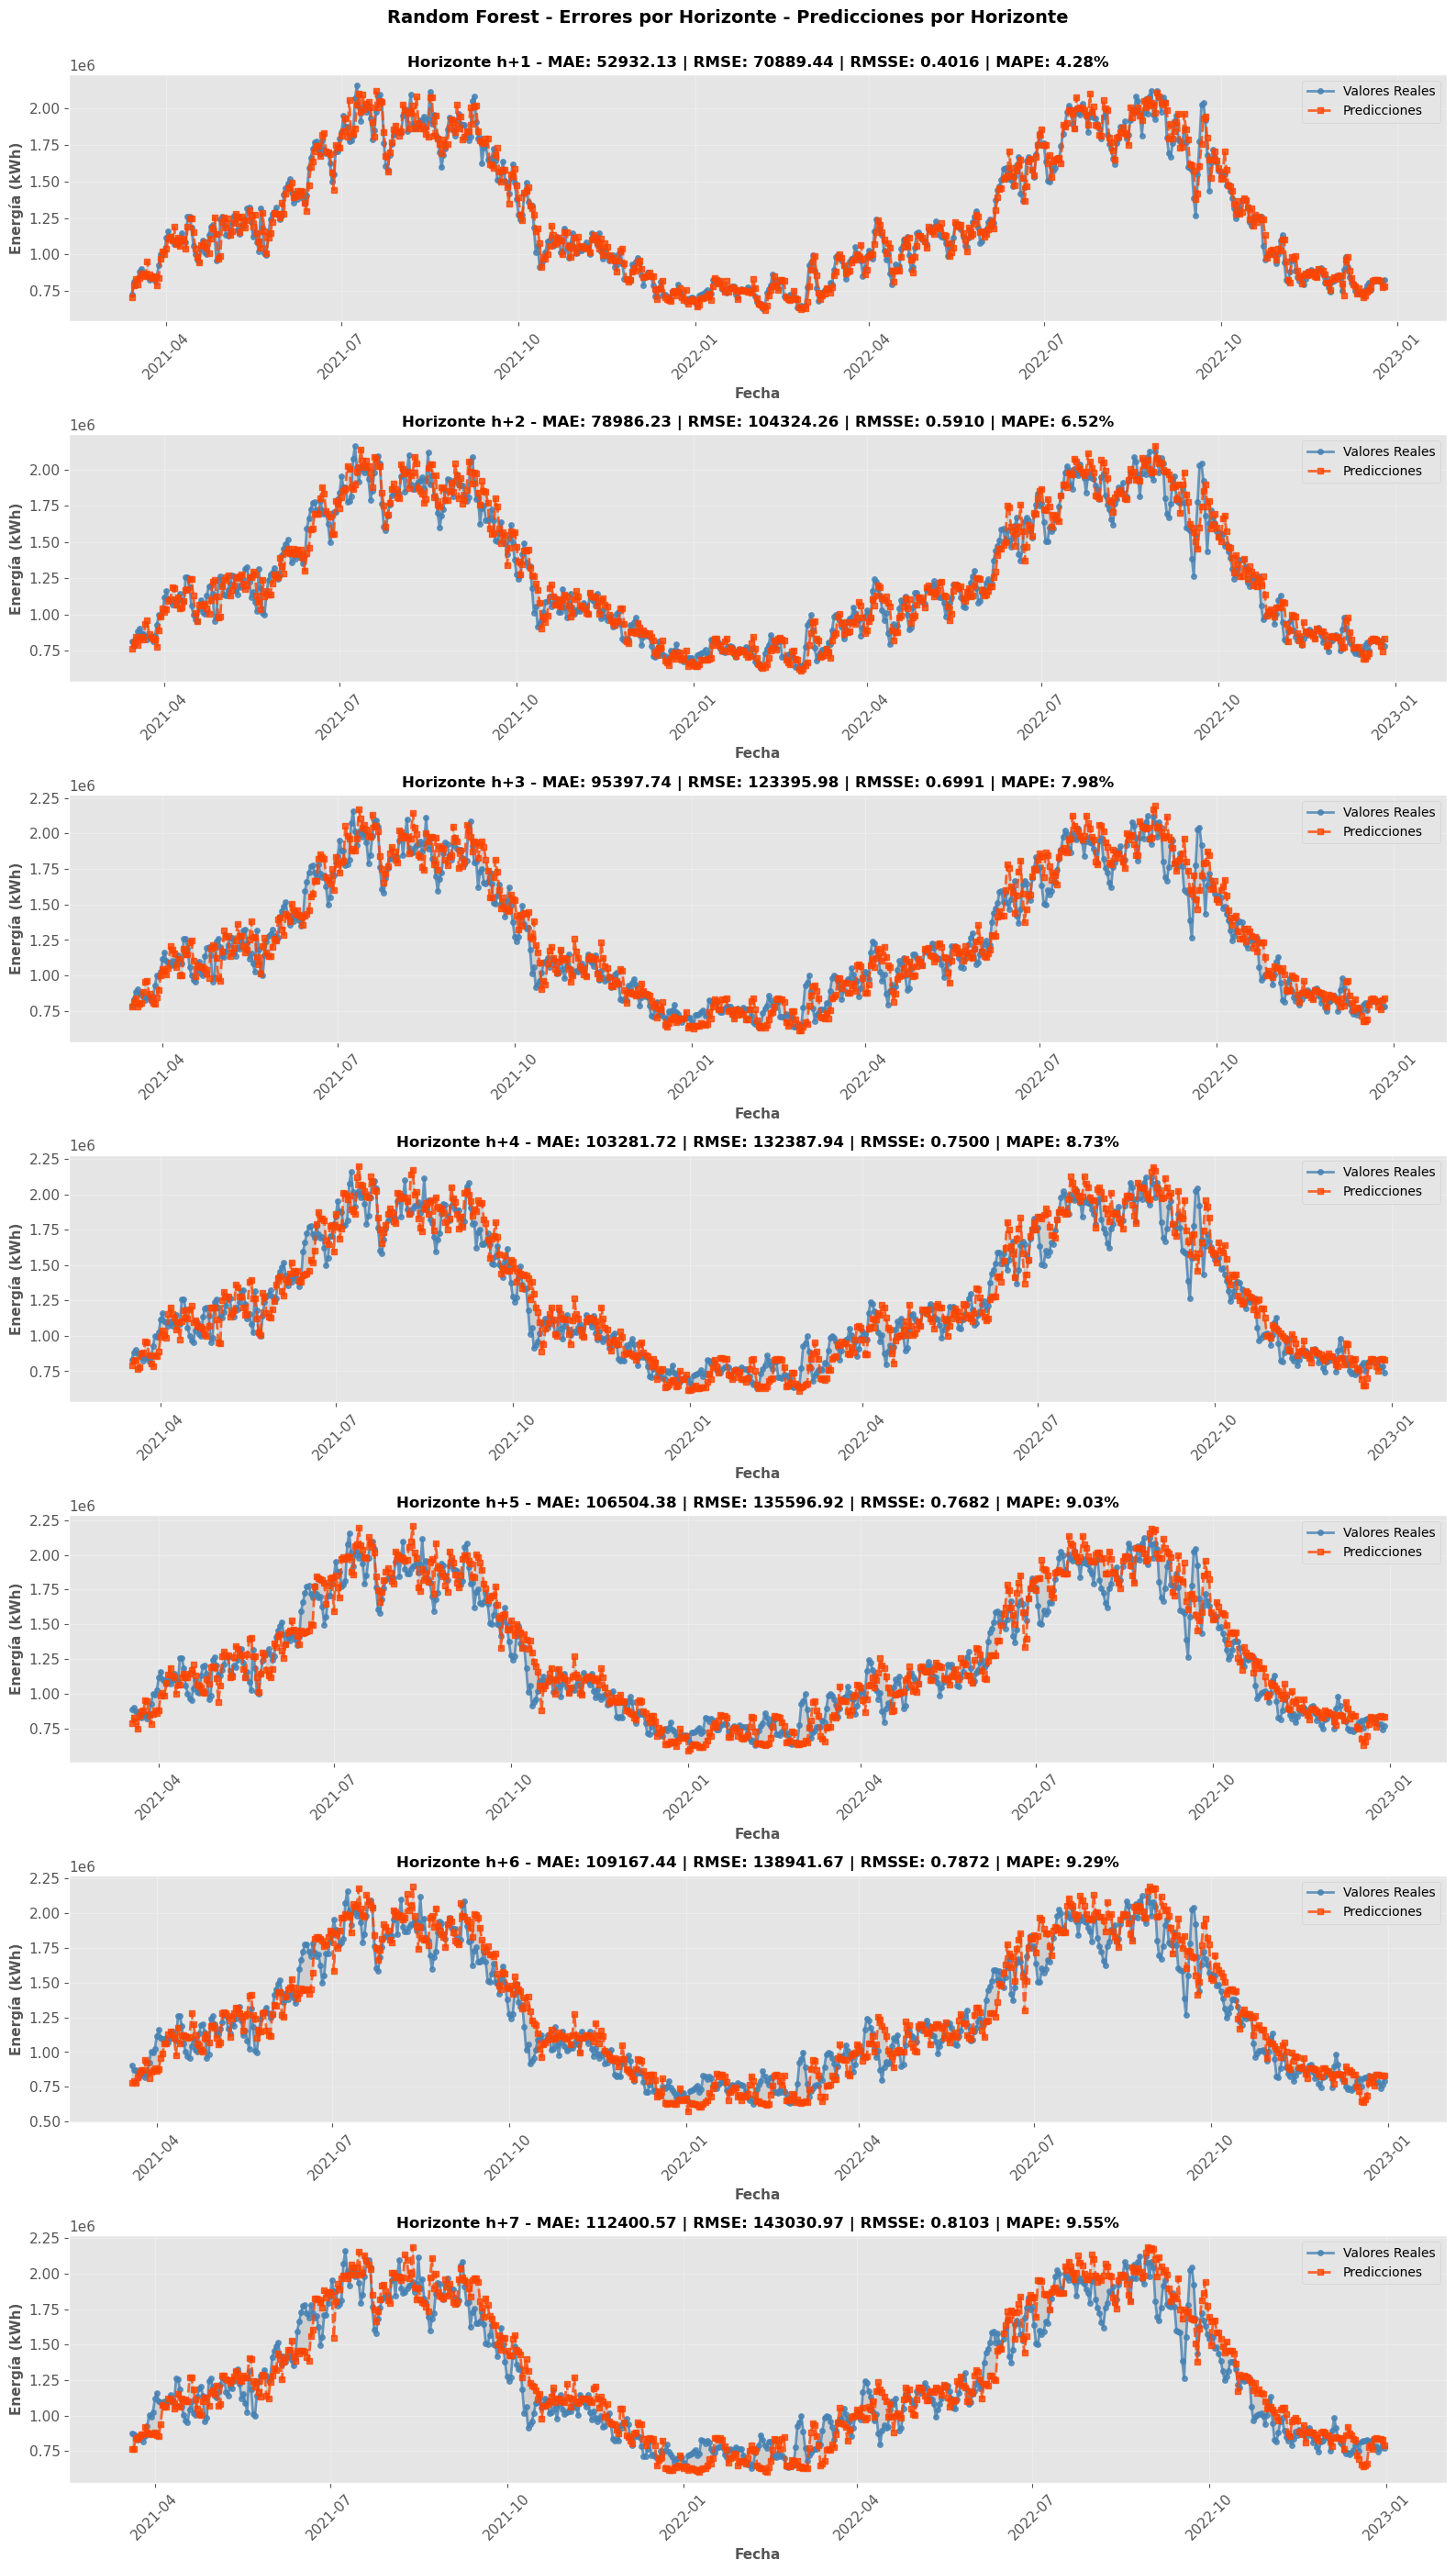

In [16]:
resultados_rf = calcular_errores_por_horizonte(
    modelo=rf_forecaster,
    test_data=test_data,
    train_data=train_data,  # Añadir esto para tener suficientes lags
    offset_lags=max(rf_forecaster.lags),
    exog_test=exog_test,
    horizonte=HORIZONTE,
    target_col=TARGET,
    verbose=True
)
visualizar_errores_horizonte(resultados_rf, titulo="Random Forest - Errores por Horizonte")

In [17]:
resultados_modelos_test.append({'Modelo': 'Random Forest - TEST'} | resultados_rf['metricas_globales'])
resultados_rf['metricas_globales']

{'MAE': 94095.74444892768,
 'RMSE': 121223.88265544765,
 'RMSSE': 0.6867781002209613,
 'MAPE': 7.909700136121075}

El modelo Random Forest en test obtiene un MAE de 94095 kWh, RMSE de 121223 kWh, RMSSE de 0.68 y MAPE de 7.90%. 

El modelo muestra discrepancia en las métricas mejorando algunas y empeorando en otras, encuanto al MAE en train teniamos 100104 kWh y pasa a 94095 en test, RMSE se reduce de 128370 a 121223 al igual que el RMSSE que pasa de 0.72 en train a 0.68 en test, mientras que el MAPE aumenta de 7.66% a 7.99%.
El modelo no presenta overfitting.

Comparando con el baseline en test (MAE: 116195 kWh, RMSE: 150707 kWh, RMSSE: 0.85, MAPE: 9.28%), Random Forest presenta un rendimiento inferior en: MAE, RMSE y MAPE. A pesar de su mayor complejidad y uso de múltiples lags, Random Forest no logra superar el modelo baseline simple, lo que indica que la configuración actual de hiperparámetros no es óptima o que el enfoque basado en media del día anterior y el mismo día del año anterior es suficientemente robusto para esta serie temporal.


Si analizamos los resultados por horizonte, vemos como Random Forest funciona mejor en horizontes pequeños empezando con un MAPE de 4,39% en el horizonte h+1 y terminando con un error de 10,34% en el horizonte h+7.

Por otro lado se puede observar como las predicciónes se adaptan bien al movimiento general de la gráfica difiriendo principalmente en entornos locales. 

Y comparando los resultados con la predicción Multivariante sin datos climáticos podemos ver que en horizontes bajos los resultados son muy parecidos pero en horizontes más altos el modelo con datos climáticos obtiene peores resultados.

### XGBoost con Grid Search <a class="anchor" id="xgboost"></a>

Se han seleccionado rangos pequeños para los hiperparámetros de XGBoost, con el objetivo de prevenir sobreajuste y agilizar la ejecución, considerando que el modelo ya va a probar múltiples lags de la variable objetivo como predictor, lo que incrementa significativamente la dimensionalidad del espacio de características (6 lags × 3 min_child_weight × 3 learning_rate x 3 max_depth = 162 combinaciones).

**learning_rate** [0.3, 0.2, 0.1]: Tasa de aprendizaje que controla la contribución de cada árbol al modelo final. Valores más bajos (0.1) hacen que el modelo aprenda de forma más conservadora, requiriendo más iteraciones pero reduciendo el riesgo de sobreajuste. Valores más altos (0.3) aceleran el aprendizaje pero pueden provocar convergencia prematura a mínimos locales. Este rango explora desde aprendizaje moderado-rápido hasta conservador.


**min_child_weight** [1, 3, 5]: Suma mínima de pesos requerida en un nodo hijo para permitir una división. Valores más altos (5) previniendo la creación de nodos con pocas observaciones y reduciendo el sobreajuste. Valores bajos (1) permiten mayor flexibilidad en las divisiones.

**max_depth** [3, 6, 9]: Profundidad máxima de cada árbol. XGBoost. El rango [3, 6, 9] permite explorar árboles muy simples y árboles moderadamente complejos. Valores bajos reducen el riesgo de memorización de patrones en entrenamiento que no existan en la realidad.

In [ ]:
# Crear forecaster directo XGB
xgb_forecaster = ForecasterDirectMultiVariate(
    regressor=XGBRegressor(random_state=SEED, n_jobs=-1, verbosity=0),
    lags=LAGS,
    transformer_series=None,
    transformer_exog=None,
    level=TARGET,
    steps=HORIZONTE
)


# Definir grid de hiperparámetros
param_grid_xgb = {
    'learning_rate': [0.3, 0.2, 0.1],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
}


# Ejecutar grid search con cv específico para validación interna
results_xgb = grid_search_forecaster_multiseries(
    forecaster=xgb_forecaster,
    param_grid=param_grid_xgb,
    lags_grid=lags_grid,
    series=train_data,  
    exog=exog_train,    
    cv=cv,              
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7 359 360 361 362 363 364 365] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3}
  Backtesting metric: 85820.72307419164
  Levels: ['Energía total (kWh)']



Podemos ver que el grid de lag con mejor resultado es el [1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 365] que captura patrones semanales y anuales, junto con los parámetros 'learning_rate': 0.2, 'max_depth': 6 y 'min_child_weight': 3. A diferencia de random forest que no utiliza patrones anuales. Y que tiene mayor profundiad.

Ahora vamos a realizar el backtesting con las particiones definidas en el apartado anterior, sobre el mejor modelo entrenado

In [19]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_xgb, predicciones_bt_xgb = backtesting_forecaster_multiseries(
    forecaster=xgb_forecaster,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_xgb = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_xgb = predicciones_bt_xgb['pred']
metricas_xgb = calcular_metricas(
    y_true_bt_xgb,
    y_pred_bt_xgb,
    y_train=train_data[TARGET].values,
    nombre_modelo="XGBoost - Backtesting"
)
resultados_modelos_cv.append(metricas_xgb)

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de XGBoost - Backtesting:
  • MAE   = 85820.723 kWh
  • RMSE  = 113911.021 kWh
  • RMSSE = 0.6453
  • MAPE  = 6.40%


El modelo XGBoost en backtesting obtiene un MAE de 85820 kWh, inferior al 113911 del modelo de linea base e inferior al 98279 del modelo Random Forest. En cuanto al RMSE obtiene un valor de 110679 ligeramente inferior al valor de Random Forest e inferior al modelo de linea base 127987. Sobre RMSSE ocurre igual que con RMSE y en MAPE obtiene mejor métrica que Random Forest y que el modelo de linea base con un 6.40%.

In [20]:
# Análisis de importancia de lags para Random Forest
import matplotlib.pyplot as plt
import pandas as pd

importance_df =xgb_forecaster.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100

print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

                       feature importance
0                        lag_1     92.32%
5                        lag_6      2.04%
6                        lag_7      1.94%
14           _level_skforecast      1.44%
12                     lag_364      0.77%
21                  dia_semana      0.30%
16         Punto de rocío (°C)      0.21%
15            Temperatura (°C)      0.16%
11                     lag_363      0.13%
4                        lag_5      0.09%
7                      lag_359      0.07%
3                        lag_4      0.07%
2                        lag_3      0.06%
19               Presión (hPa)      0.05%
18  Velocidad del viento (m/s)      0.05%
9                      lag_361      0.05%
13                     lag_365      0.05%
17                 Humedad (%)      0.05%
8                      lag_360      0.04%
1                        lag_2      0.04%


Encuanto a la importancia de las características el 'lag_1' vuelve a destacar como el más importante para la predicción aunque con un valor inferior al que da Random Forest. Este modelo tambien da importancia al lag_7 y lag_6 capturando mejor la estacionalidad semanal y el lag 364 que capturan estacionalidad anual. 'dia_semana' pierde relevancia en comparación con el Random Forest al igual que 'Temperatura (°C)'.

Ahora analizaremos los resultados del mejor modelo en datos de test. Y por horizonte temporal.

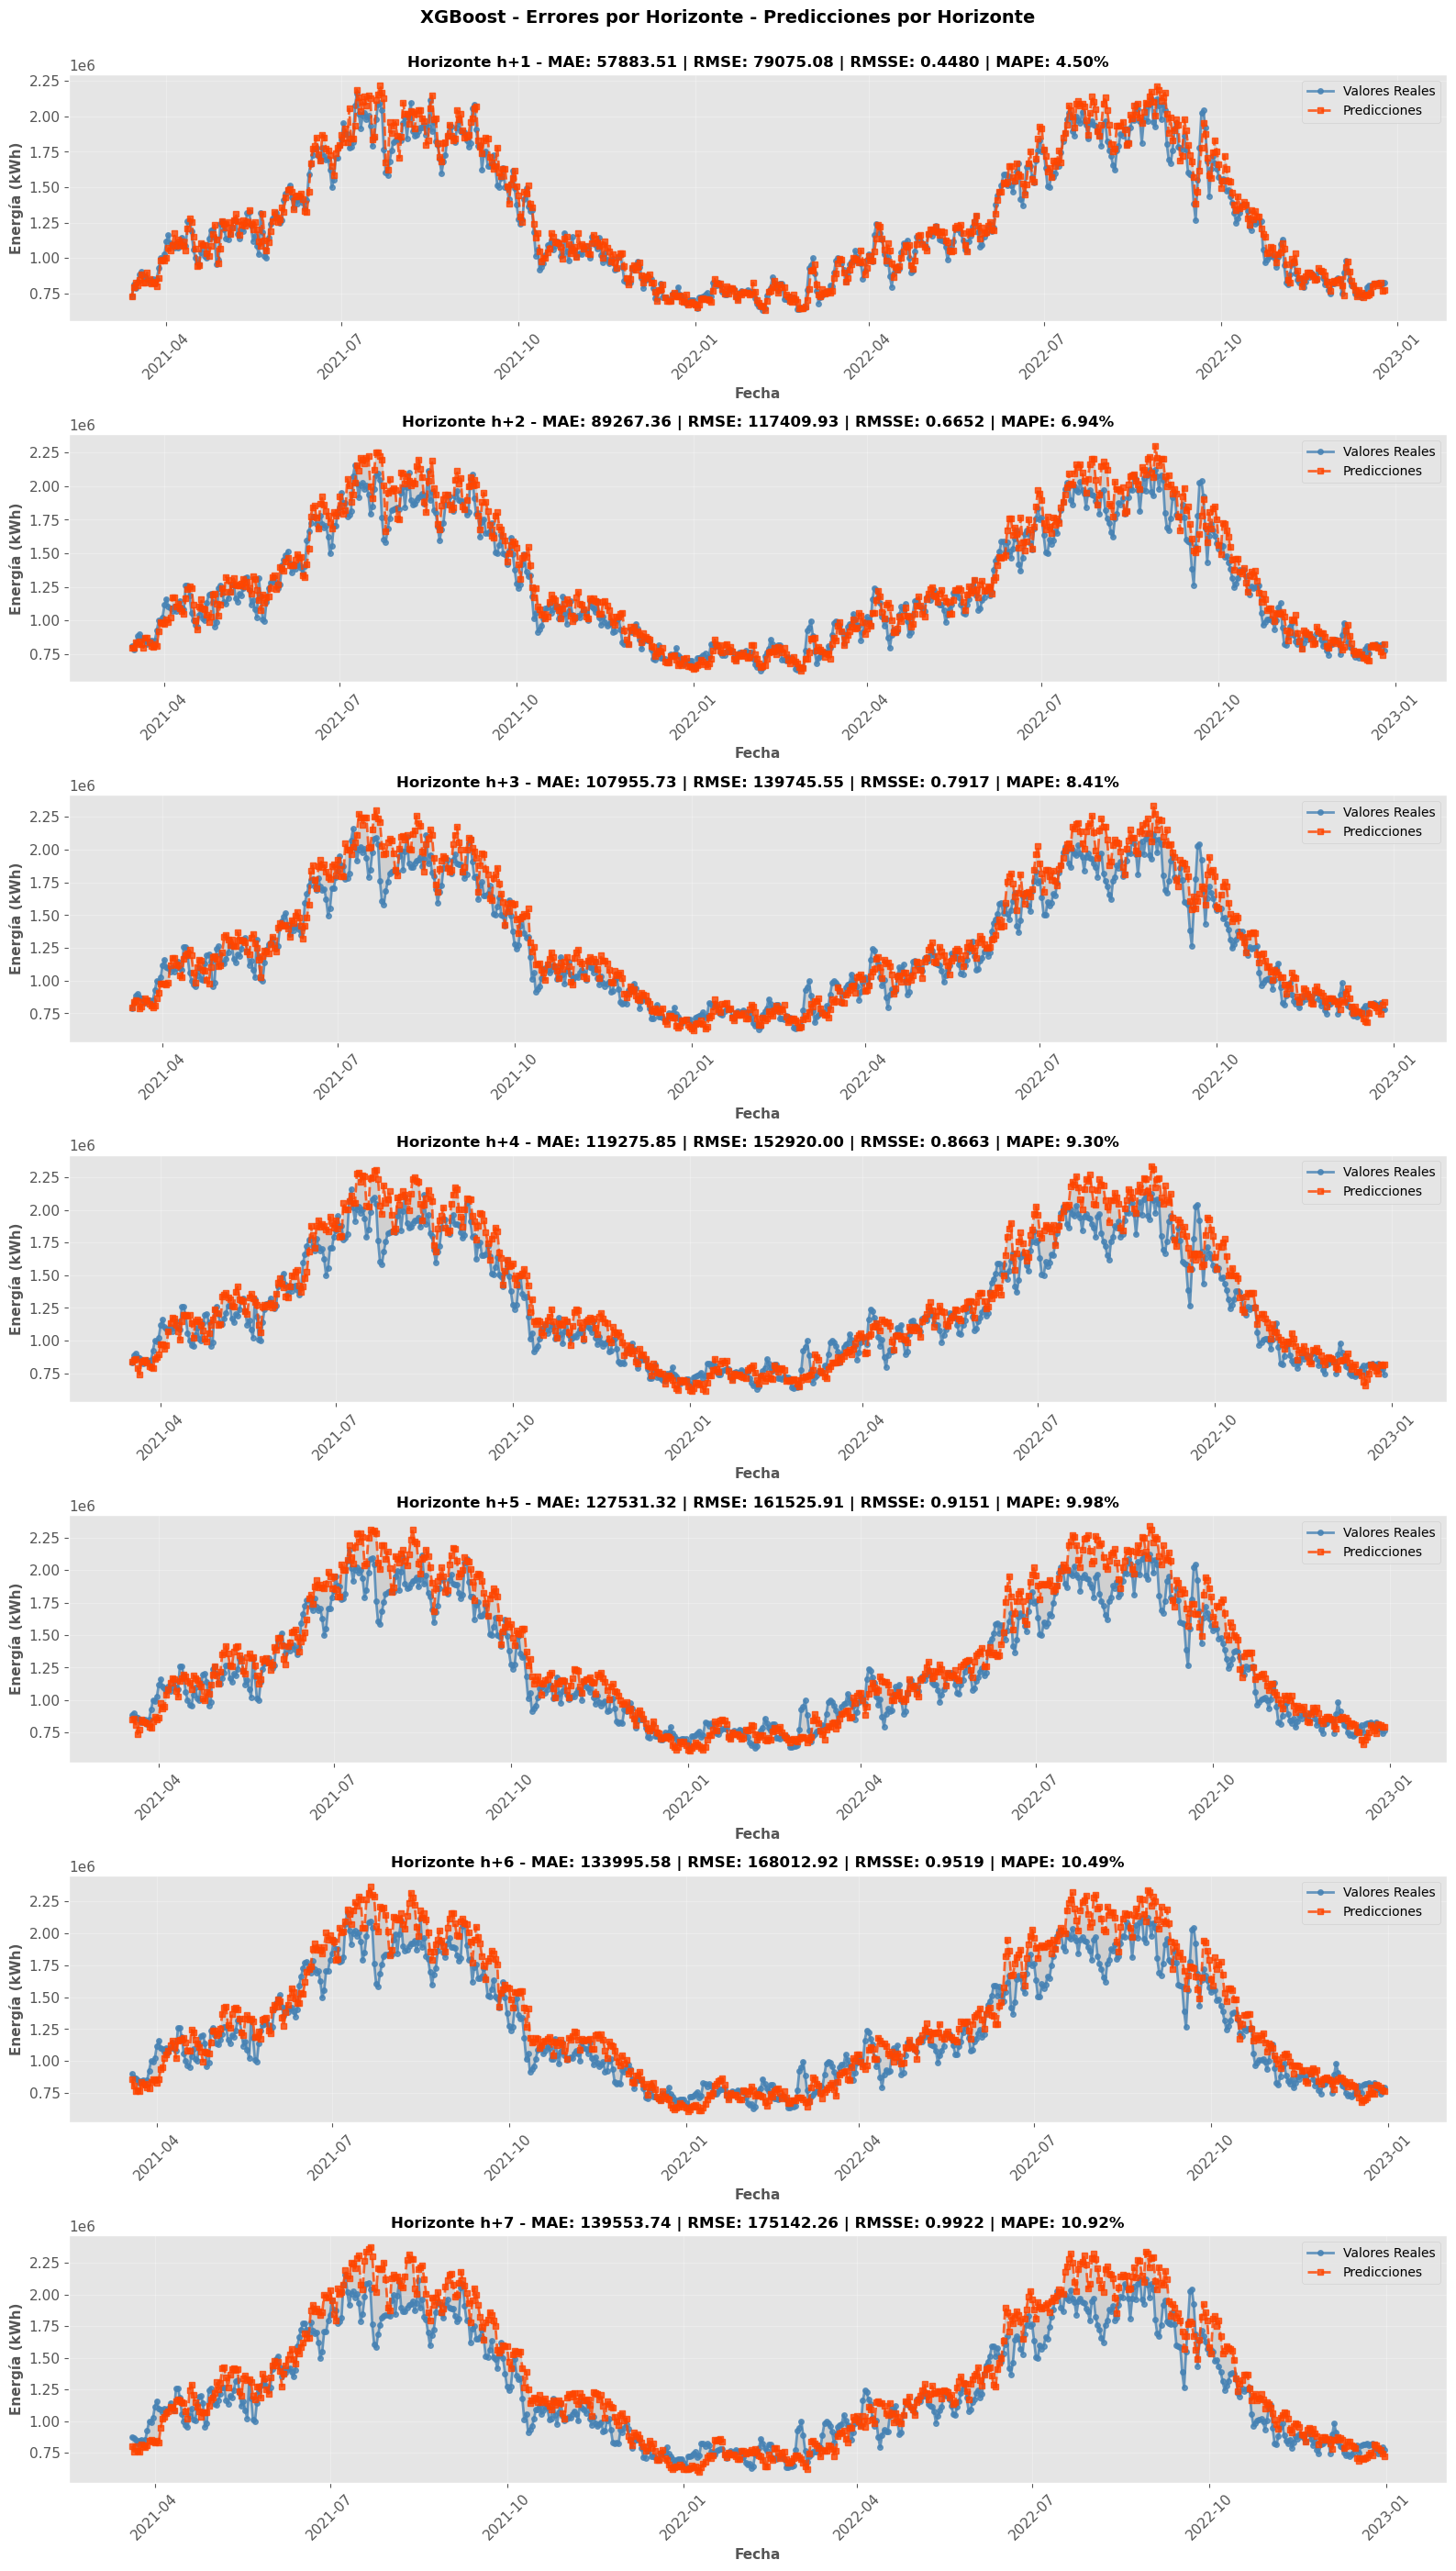

In [21]:
resultados_xgb = calcular_errores_por_horizonte(
    modelo=xgb_forecaster,
    test_data=test_data,
    train_data=train_data,  # Añadir esto para tener suficientes lags
    offset_lags=max(xgb_forecaster.lags),
    exog_test=exog_test,
    horizonte=HORIZONTE,
    target_col=TARGET,
    verbose=True
)
visualizar_errores_horizonte(resultados_xgb, titulo="XGBoost - Errores por Horizonte")

In [22]:
resultados_modelos_test.append({'Modelo': 'XGBoost - TEST'} | resultados_xgb['metricas_globales'])

resultados_xgb['metricas_globales']

{'MAE': 110780.44094318428,
 'RMSE': 141975.95092343175,
 'RMSSE': 0.8043462370315121,
 'MAPE': 8.649190567708462}

Analizando las métricas de resultados en TEST podemos ver que no hay overfitting aunque si que empeoran los resultados en test considerablemente en todas las métricas. El modelo consigue en train un MAE de 85820 vs 110780 en test. En cuanto al RMSE consigue un valor de 113911 en train vs un 141975 en test. Para RMSSE se consigue un valor de 0.64 en train frente a un 0.80 en test y por último el MAPE es de 6.40% en train vs 8.64% en test.

### SVR con Grid Search <a class="anchor" id="svr"></a>

Se han seleccionado rangos pequeños para los hiperparámetros de XGBoost, con el objetivo de prevenir sobreajuste y agilizar la ejecución, considerando que el modelo ya va a probar múltiples lags de la variable objetivo como predictor, lo que incrementa significativamente la dimensionalidad del espacio de características (6 lags × 3 C × 3 epsilon x 3 gamma = 162 combinaciones).

**C** [0.1, 1, 10]: Parámetro de regularización que controla el trade-off entre maximizar el margen y minimizar el error de entrenamiento. Valores bajos (0.1) permiten mayor violación del margen, favoreciendo generalización a costa de mayor error en train. Valores altos (10) penalizan fuertemente los errores, ajustándose más a los datos de entrenamiento con riesgo de sobreajuste.

**epsilon** [0.01, 0.1, 0.5]: Valores pequeños (0.01) exigen predicciones muy precisas, creando un modelo más ajustado. Valores grandes (0.5) permiten mayor tolerancia a errores pequeños, resultando en modelos más simples y robustos.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Crear forecaster con datos normalizados (importante para SVR) - Direct MultiVariate
svr_forecaster = ForecasterDirectMultiVariate(
    regressor=SVR(),
    lags=LAGS,
    transformer_series=StandardScaler(), # Escalar los datos de la serie
    transformer_exog=StandardScaler(),
    level=TARGET,
    steps=HORIZONTE
)

# Definir grid de hiperparámetros
param_grid_svr = {
    'C': [0.01, 0.01, 1],
    'epsilon': [0.001, 0.005, 0.01],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.001, 0.005]
}

# Ejecutar grid search con cv específico para validación interna
# IMPORTANTE: Usar datos ESCALADOS para SVR
results_svr = grid_search_forecaster_multiseries(
    forecaster=svr_forecaster,
    param_grid=param_grid_svr,
    lags_grid=lags_grid,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
  Backtesting metric: 89395.24374857763
  Levels: ['Energía total (kWh)']



Podemos ver que el grid de lag con mejor resultado es el [1, 2, 3, 4, 5, 6, 7] que captura patrones semanales, junto con los parámetros 'C': 1, 'epsilon': 0.01, 'gamma': 'scale' y 'kernel': 'rbf'.

Ahora vamos a realizar el backtesting con las particiones definidas en el apartado anterior, sobre el mejor modelo entrenado

In [24]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_svr, predicciones_bt_svr = backtesting_forecaster_multiseries(
    forecaster=svr_forecaster,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_svr = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_svr = predicciones_bt_svr['pred']
metricas_svr = calcular_metricas(
    y_true_bt_svr,
    y_pred_bt_svr,
    y_train=train_data[TARGET].values,
    nombre_modelo="SVR - Backtesting"
)
resultados_modelos_cv.append(metricas_svr)

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de SVR - Backtesting:
  • MAE   = 89395.244 kWh
  • RMSE  = 118896.592 kWh
  • RMSSE = 0.6736
  • MAPE  = 6.77%


El modelo SVR en backtesting obtiene un MAE de 89395 kWh, ligeramente inferior al 106552 del modelo de linea base e inferior al resultado de XGBoost y Random Forest. En cuanto al RMSE obtiene un valor de 118896 superior al valor de Random Forest y XGBoost, pero inferior al modelo de linea base. Sobre RMSSE ocurre igual que con RMSE y en MAPE tambien obtiene métricas peores que Random Forest y XGBoost, pero mejores que el modelo de linea base.

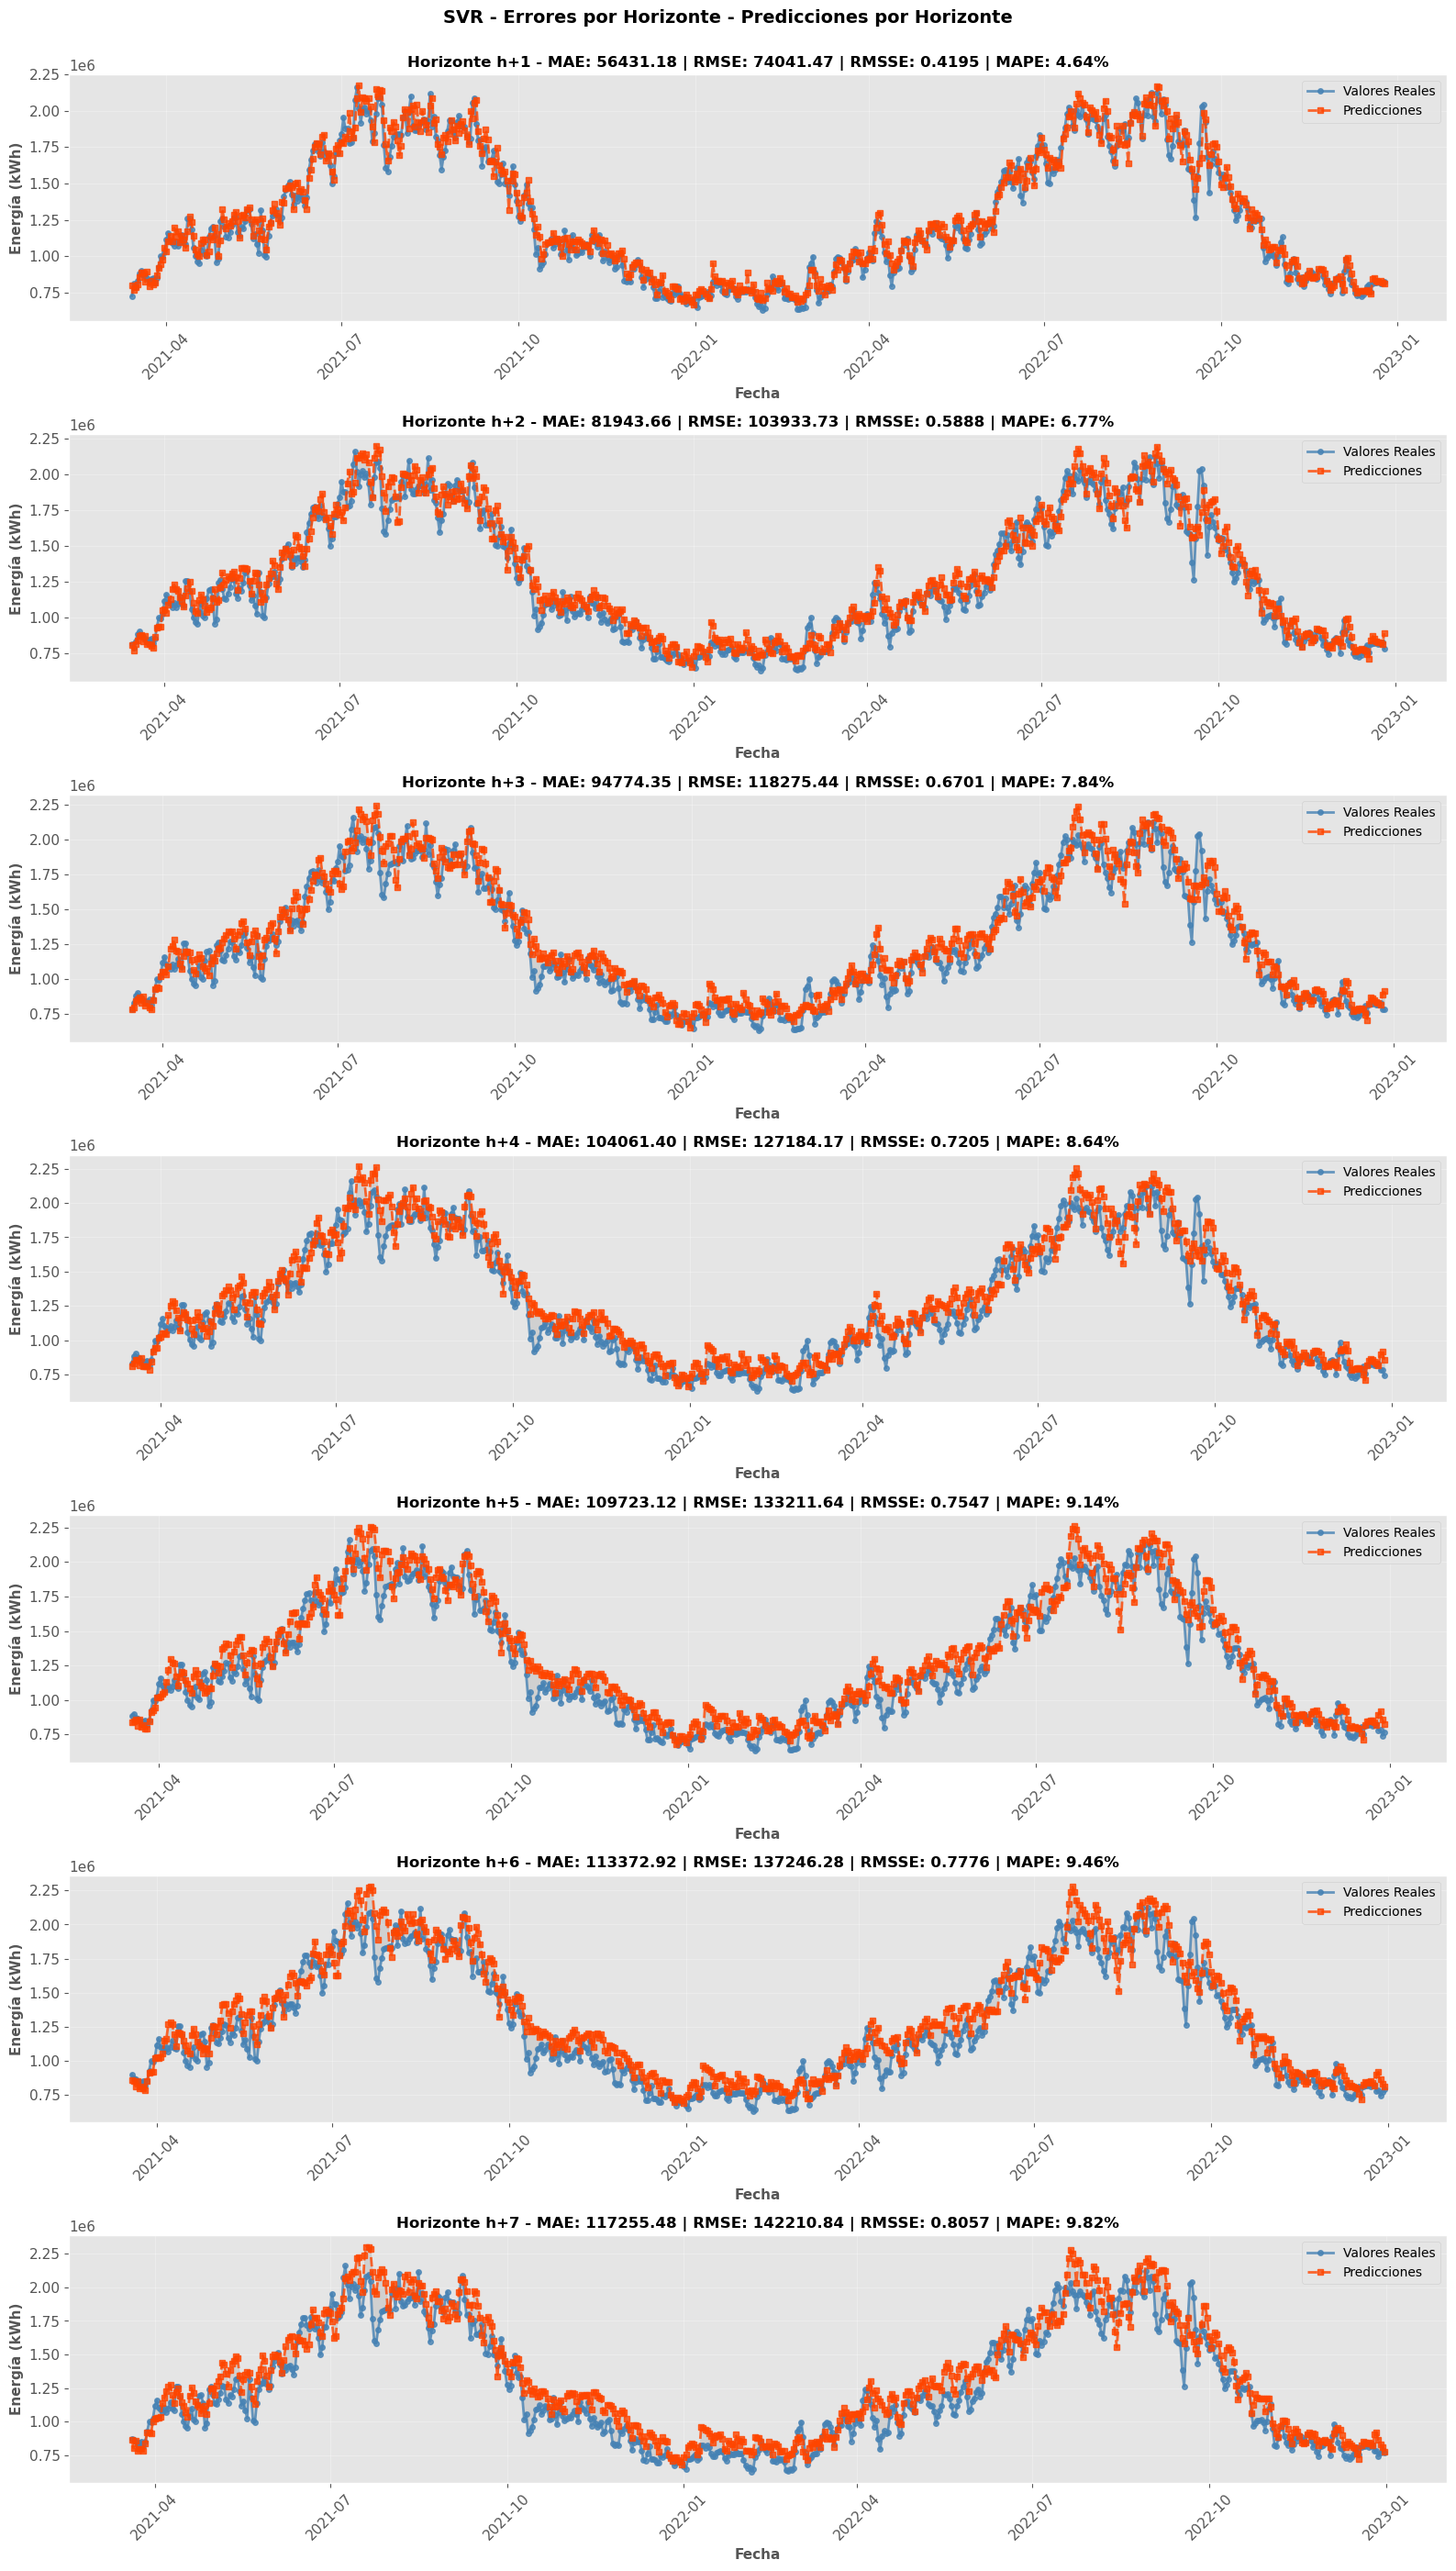

In [25]:
resultados_svr = calcular_errores_por_horizonte(
    modelo=svr_forecaster,
    test_data=test_data,
    train_data=train_data,  # Añadir esto para tener suficientes lags
    offset_lags=max(svr_forecaster.lags),
    exog_test=exog_test,
    horizonte=HORIZONTE,
    target_col=TARGET,
    verbose=True
)
visualizar_errores_horizonte(resultados_svr, titulo="SVR - Errores por Horizonte")

In [26]:
resultados_modelos_test.append({'Modelo': 'SVR - TEST'} | resultados_svr['metricas_globales'])

resultados_svr['metricas_globales']

{'MAE': 96794.5878655988,
 'RMSE': 119443.36686760312,
 'RMSSE': 0.6766908201949214,
 'MAPE': 8.043906706227341}

Analizando las métricas de resultados en TEST podemos ver que no hay overfitting y que los datos de TEST son peores que los de train en todas las métricas. El modelo consigue en train un MAE de 89395 vs 96794 en test. En cuanto al RMSE consigue un valor de 118896 en train vs un 119443 en test. Para RMSSE se consigue un valor de 0.6736 en train frente a un 0.6766 en test y por último el MAPE es de 6.77% en train vs 8.04% en test. Los valores son suficientemente cercanos para considerar que el modelo generaliza bien. 

Encuanto a la comparativa con el modelo baseline. No conseguimos mejorar ninguna métrica. Lo cual indica que el modelo con estos parámetros no es suficientemente ajustado o que el modelo baseline es suficientemente robusto. Pero si que conseguimos mejorar los resultados de test de Random Forest y XGBoost. Este es hasta ahora el mejor modelo de ML entrenado con estrategias multivariantes.

Comparando métricas por horizonte los errores van aumentando conforme aumenta el horizonte, empezando en un MAPE de 4.64% en h+1 y terminando en un MAPE de 9.82% en h+7.

## Comparación y Conclusiones <a class="anchor" id="conclu"></a>

En esta sección final comparamos todos los modelos entrenados y presentamos las conclusiones más relevantes del análisis.

- 1 Baseline (Solución naive)
- 3 Modelos Directos (Random Forest, XGBoost, SVR)

In [27]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados_modelos_cv)
df_resultados = df_resultados.sort_values('MAE')

print("\nTABLA DE RESULTADOS (ordenado por MAE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_mae = df_resultados[df_resultados['Modelo'] == 'Baseline Simple - TRAIN (media horizontes)']['MAE'].values[0]
mejor_mae = df_resultados.iloc[0]['MAE']
mejora = ((baseline_mae - mejor_mae) / baseline_mae) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en MAE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE','RMSE','MAPE'], cmap='RdYlGn_r')
                          .format({'MAE': '{:.3f}', 'RMSE': '{:.4f}', 'RMSSE': '{:.4f}', 'MAPE': '{:.2f}%'}))


TABLA DE RESULTADOS (ordenado por MAE):

                                    Modelo           MAE          RMSE    RMSSE      MAPE
                     XGBoost - Backtesting  85820.723074 113911.020922 0.645348  6.397877
                         SVR - Backtesting  89395.243749 118896.591720 0.673593  6.771039
               Random Forest - Backtesting 100104.320585 128370.124383 0.727264  7.659819
Baseline Simple - TRAIN (media horizontes) 156234.992846 202855.943348 1.149254 11.842745

Mejora respecto al baseline: 45.07% en MAE


Como hemos ido viendo el modelo baseline simple que hemos realizado con la media del dia anterior y el valor del mismo día del año anterior funciona peor que todos los modelos entrenados en backtesting. Los modelos se ajustan bien a los datos de entrenamiento. Pero como veremos en la siguiente tabla eso no se traduce en unos mejores resultados en test.

Por otro lado destacan  los lags 1 y 7 como los más útiles para realizar las predicciones. Subrayando la estacionalidad semanal de la serie. Mientras que las variables climáticas no han aportado un gran valor a los modelos, siendo la más relevante 'Temperatura (Cº)'




In [28]:
# Crear DataFrame con resultados
df_resultados_test = pd.DataFrame(resultados_modelos_test)
df_resultados_test = df_resultados_test.sort_values('MAE')

print("\nTABLA DE RESULTADOS (ordenado por MAE):")
print("\n" + df_resultados_test.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados_test.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_mae = df_resultados_test[df_resultados_test['Modelo'] == 'Baseline Simple - TEST (media horizontes)']['MAE'].values[0]
mejor_mae = df_resultados_test.iloc[0]['MAE']
mejora = ((baseline_mae - mejor_mae) / baseline_mae) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en MAE")

display(df_resultados_test.style.background_gradient(subset=['MAE', 'RMSSE','RMSE','MAPE'], cmap='RdYlGn_r')
                          .format({'MAE': '{:.3f}', 'RMSE': '{:.4f}', 'RMSSE': '{:.4f}', 'MAPE': '{:.2f}%'}))


TABLA DE RESULTADOS (ordenado por MAE):

                                   Modelo           MAE          RMSE    RMSSE     MAPE
                     Random Forest - TEST  94095.744449 121223.882655 0.686778 7.909700
                               SVR - TEST  96794.587866 119443.366868 0.676691 8.043907
                           XGBoost - TEST 110780.440943 141975.950923 0.804346 8.649191
Baseline Simple - TEST (media horizontes) 116195.489645 150707.124421 0.853812 9.283540

Mejora respecto al baseline: 19.02% en MAE


En datos de test podemos ver que no hay overfitting pero si que empeoran los resultados con respecto al backtesting, y mejoramos los resultados con respecto al modelo de linea base, el mejor modelo sería el Random Forest. A diferencia de con sin usar los datos climáticos que era el SVR.

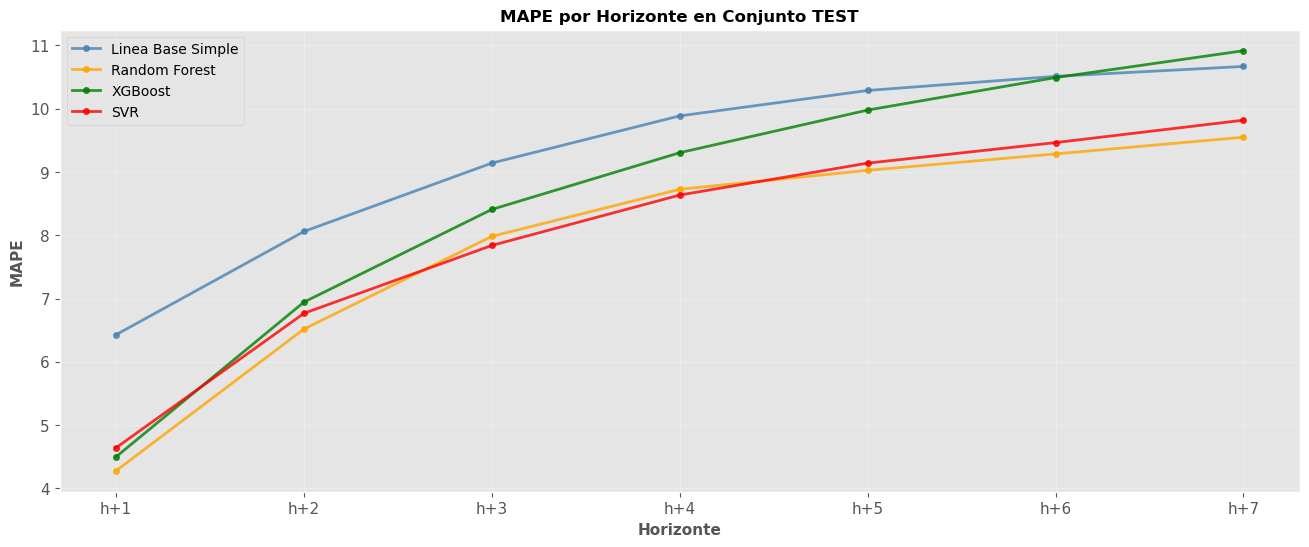

In [29]:
# Visualizar MAPE por horizonte para todos los modelos en TEST
fig,ax = plt.subplots(figsize=(16, 6))

ax.plot(dict_visualizacion_test['metricas_por_horizonte']['Horizonte'],
        dict_visualizacion_test['metricas_por_horizonte']['MAPE'], 
       'o-', color='steelblue', label='Linea Base Simple', 
       linewidth=2, markersize=4, alpha=0.8)

ax.plot(resultados_rf['metricas_por_horizonte']['Horizonte'],
        resultados_rf['metricas_por_horizonte']['MAPE'], 
       'o-', color='orange', label='Random Forest', 
       linewidth=2, markersize=4, alpha=0.8)

ax.plot(resultados_xgb['metricas_por_horizonte']['Horizonte'],
        resultados_xgb['metricas_por_horizonte']['MAPE'], 
       'o-', color='green', label='XGBoost', 
       linewidth=2, markersize=4, alpha=0.8)

ax.plot(resultados_svr['metricas_por_horizonte']['Horizonte'],
        resultados_svr['metricas_por_horizonte']['MAPE'], 
       'o-', color='red', label='SVR', 
       linewidth=2, markersize=4, alpha=0.8)

ax.set_xlabel('Horizonte', fontsize=11, fontweight='bold')
ax.set_ylabel('MAPE', fontsize=11, fontweight='bold')
ax.set_title(f'MAPE por Horizonte en Conjunto TEST', 
            fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

Random Forest es el mejor con un MAE de 94095 kWh, RMSE de 121223 kWh, RMSSE de 0.6868 y MAPE de 7.91%. Sin embargo, no mejora las predicciones del modelo multivariante sin datos climáticos del apartado anterior.

El ajuste de hiperparámetros se realizó mediante Grid Search con validación temporal, utilizando TimeSeriesFold con un tamaño inicial de 1,095 días, ventana deslizante de 365 días y horizonte de 7 días. Se han explorado múltiples configuraciones de lags estratégicos que capturan estacionalidad semanal (lag 7), mensual (lag 30), semestral (lag 183) y anual (lags 359-365), además de patrones recientes (lags 1-7). Aunque la mejor configuración de lags no es unánime entre todos los modelos, si que hay una configuración que es mejor en 2 de 3 modelos: [1, 2, 3, 4, 5, 6, 359, 360, 361, 362, 363, 364, 365]. Esta configuración captura estacionalidad semanal y anual sin sobre cargar los modelos.

Todos los modelos mostraron un patrón consistente donde el mejor rendimiento se alcanza en h+1, degradándose progresivamente con cada horizonte adicional. Los modelos complejos son superiores al baseline en todos los horizontes, salvo XGBOOST en el horizonte 7.

El análisis de importancia reveló un patrón consistente donde lag_1 (día anterior) y lag_7 (estacionalidad semanal) son las variables más importantes. Además en la variable exógena de Temperatura tambien destaca como importante.



## Entorno de Ejecución <a class="anchor" id="entorno"></a>

In [30]:
import sklearn
sklearn.show_versions()


System:
    python: 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:27:59) [MSC v.1937 64 bit (AMD64)]
executable: c:\Users\AntonioLuisTorres\.conda\envs\NuCLS-tfg\python.exe
   machine: Windows-10-10.0.19045-SP0

Python dependencies:
      sklearn: 1.7.2
          pip: 24.0
   setuptools: 69.0.3
        numpy: 1.26.3
        scipy: 1.12.0
       Cython: 3.0.8
       pandas: 2.2.0
   matplotlib: 3.8.2
       joblib: 1.3.2
threadpoolctl: 3.3.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: mkl
    num_threads: 6
         prefix: libblas
       filepath: C:\Users\AntonioLuisTorres\.conda\envs\NuCLS-tfg\Library\bin\libblas.dll
        version: 2024.0-Product
threading_layer: intel

       user_api: openmp
   internal_api: openmp
    num_threads: 12
         prefix: vcomp
       filepath: C:\Users\AntonioLuisTorres\.conda\envs\NuCLS-tfg\vcomp140.dll
        version: None

       user_api: openmp
   internal_api: openmp
    num_threads: 12
  

In [31]:
from sinfo import sinfo

sinfo()

-----
lightgbm    4.6.0
matplotlib  3.8.2
numpy       1.26.3
pandas      2.2.0
seaborn     0.13.2
sinfo       0.3.1
skforecast  0.19.1
sklearn     1.7.2
sktime      0.40.1
xgboost     3.1.2
-----
IPython             8.22.1
jupyter_client      8.6.0
jupyter_core        5.7.1
jupyterlab          4.1.2
notebook            7.1.1
-----
Python 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:27:59) [MSC v.1937 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
12 logical CPU cores, Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
-----
Session information updated at 2026-01-07 23:59
